In [8]:
# Basic imports
import os
import sys
import time
import timeit
import random
import pickle
import re
from itertools import product
import warnings

# System path modification
sys.path.insert(0, '..')

# Data handling
import pandas as pd
import numpy as np

# Machine learning imports
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer, MissingIndicator
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, GroupKFold, StratifiedGroupKFold, LeaveOneOut, cross_validate, cross_val_score
)
from sklearn.linear_model import (
    LinearRegression, Lasso, LassoCV, MultiTaskLasso, MultiTaskLassoCV,
    ElasticNet, ElasticNetCV, MultiTaskElasticNet, MultiTaskElasticNetCV
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

from sklearn.cross_decomposition import PLSRegression
from sklearn.inspection import permutation_importance


# Statistic imports 
from scipy.stats import ks_2samp
from scipy.special import kl_div
from scipy.cluster.hierarchy import linkage, leaves_list
from scipy.spatial.distance import pdist, squareform

# Specialized imputation and visualization packages
import miceforest as mf
import missingno as msno
#from missforest import MissForest
#import magic
from src.gain import *

# Custom modules
from src.train import *
from src.functions import *
from src.plots import *
from src.dataset import *
from src.multixgboost import *
from src.wrapper import *

# Visualizatiokn 
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and machine learning specific 
import torch
from pytorch_tabnet.tab_model import TabNetRegressor
import xgboost as xgb
import shap

# Ignore warnings
warnings.filterwarnings("ignore")

# Print CUDA availability for PyTorch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

False
0


## Load data 

In [9]:
data = load_pickle_data_palettes()

# Unpack data
df_X, df_y, df_all, df_FinalCombination = data["df_X"], data["df_y"], data["df_all"], data["df_FinalCombination"]
df_select_features, miss_mask = data["df_select_features"], data["miss_mask"]

# Unpack feature selections
select_RNA, select_CSF, select_gene, select_MRIthickness, select_MRIvolume, select_PET = df_select_features.T.values

# Unpack colormaps
full_palette, gender_palette, dx_palette = data["colormaps"].values()

df_X = df_X[miss_mask]
df_y = df_y[miss_mask]
df_all = df_all[miss_mask]

# Leave-One-Complete-Out (LOCO-CV)

In [10]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

print(sum(idx_test))

print(df_all[idx_test].RID)

df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")

test_indices = [i for i, val in enumerate(idx_test) if val]

12
4610    2002
5511    2374
6329    4167
6400    4176
6421    4179
6634    4215
7007    4292
7052    4300
7242    4349
7822    4453
7981    4489
8061    4505
Name: RID, dtype: int64


In [11]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    #("SimpleImputer_mean", SimpleImputer(strategy="mean")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("KNNImputer_2", KNNImputer(n_neighbors=2)),
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("SimpleImputer_most_frequent", SimpleImputer(strategy="most_frequent")),
    ("KNNImputer", KNNImputer(n_neighbors=1)),
    ("SimpleImputer_constant", SimpleImputer(strategy="constant", fill_value=-1))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("MultiTaskElasticNet", MultiTaskElasticNet()),
    ("MultiTaskLasso", MultiTaskLasso()),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("XGBoostRegressor", XGBoostRegressor()),
    ("TabNetRegressor_default", TabNetModelWrapper(n_a=8, n_d=8)),
    ("TabNetRegressor_custom", TabNetModelWrapper(n_a=32, n_d=32)),
    ("PLSRegression_2_components", PLSRegression(n_components=2)),
    ("PLSRegression_4_components", PLSRegression(n_components=4)),
    ("PLSRegression_6_components", PLSRegression(n_components=6)),    
    ("PLSRegression_10_components", PLSRegression(n_components=10))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: LinearRegression
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskElasticNet
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: MultiTaskLasso
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: RandomForestRegressor
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: XGBoostRegressor
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: TabNetRegressor_default
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: TabNetRegressor_custom
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: PLSRegression_2_components
Continuous Imputer: KNNImputer, Ordinal Imputer: SimpleImputer_most_frequent, Model: PLSRegression_4_components
Continuous Imputer: KNNImputer, Ordinal Imp

In [12]:
# Initialize HDF5 file
results_file = '../pickle/training_3_loonona_dict_results.pickle'

In [13]:
if os.path.exists(results_file): 
    with open(results_file, "rb") as input_file:
        all_dict_results = pickle.load(input_file)

else : 
    all_dict_results = []

ModuleNotFoundError: No module named 'numpy._core.numeric'

In [ ]:
all_dict_results[0]["params"]

{'ordinal_imputer': 'SimpleImputer_most_frequent',
 'continuous_imputer': 'KNNImputer',
 'model': 'LinearRegression',
 'train_shape': [2882, 261],
 'test_shape': [12, 261]}

In [ ]:
all_dict_results[-1]["params"]

{'ordinal_imputer': 'SimpleImputer_constant',
 'continuous_imputer': 'KNNImputer_2',
 'model': 'PLSRegression_10_components',
 'train_shape': [2893, 261],
 'test_shape': [1, 261]}

In [ ]:
len(all_dict_results)

77

In [ ]:
for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    params = {
            "ordinal_imputer": name_ordinal_imputer, 
            "continuous_imputer": name_continuous_imputer, 
            "model": name_model, "train_shape" : [df_X.shape[0]-1, df_X.shape[1]],
            "test_shape": [1, df_X.shape[1]]
        }
    
    # Define the subset of keys you care about
    keys_to_check = ['ordinal_imputer', 'continuous_imputer', 'model']  # or whatever subset you want

    # Check if a result in all_dict_results has the same values for just those keys
    if any(all(result['params'].get(k) == params.get(k) for k in keys_to_check) for result in all_dict_results):
        print(f"Skipping existing combination (subset match): {[params[k] for k in keys_to_check]}")
        continue

    dict_results = {
            "params": params, 
            "imputation_time": [],
            "fitting_time": [], 
            "results_adj": [], 
            "results_org": []
        }

    for test_nloc in test_indices: 
        print(test_nloc)

        idx_train = [True for i in range(df_X.shape[0])]
        idx_test = [False for i in range(df_X.shape[0])]

        idx_test[test_nloc] = True
        idx_train[test_nloc] = False

        df_X_train = df_X.loc[idx_train]
        df_X_test = df_X.loc[idx_test]

        df_y_train = df_y.loc[idx_train]
        df_y_test = df_y.loc[idx_test]

        c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
        c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

        try: 
        
            # Now you can call your `train_model` function with these components
            fold_dict_results = train_imputer_model(
                df_X_train, df_X_test, df_y_train, df_y_test,
                c_train, c_test,
                ordinal_imputer_instance, name_ordinal_imputer,
                continuous_imputer_instance, name_continuous_imputer,
                model_instance, name_model,
                separate_imputers=True  # Or however you want to specify
            )
            
            dict_results["imputation_time"].append(fold_dict_results["imputation_time"]) 
            dict_results["fitting_time"].append(fold_dict_results["fitting_time"])  
            dict_results["results_adj"].append(fold_dict_results["results_adj"])  
            dict_results["results_org"].append(fold_dict_results["results_org"])  

        except Exception as e:  

            print(e)
            
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)

    # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


Skipping existing combination (subset match): ['SimpleImputer_most_frequent', 'KNNImputer', 'LinearRegression']
Skipping existing combination (subset match): ['SimpleImputer_most_frequent', 'KNNImputer', 'MultiTaskElasticNet']
Skipping existing combination (subset match): ['SimpleImputer_most_frequent', 'KNNImputer', 'MultiTaskLasso']
Skipping existing combination (subset match): ['SimpleImputer_most_frequent', 'KNNImputer', 'RandomForestRegressor']
Skipping existing combination (subset match): ['SimpleImputer_most_frequent', 'KNNImputer', 'XGBoostRegressor']
Skipping existing combination (subset match): ['SimpleImputer_most_frequent', 'KNNImputer', 'TabNetRegressor_default']
Skipping existing combination (subset match): ['SimpleImputer_most_frequent', 'KNNImputer', 'TabNetRegressor_custom']
Skipping existing combination (subset match): ['SimpleImputer_most_frequent', 'KNNImputer', 'PLSRegression_2_components']
Skipping existing combination (subset match): ['SimpleImputer_most_frequent

In [ ]:
# Store data (serialize)
with open(results_file, 'wb') as handle:
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
results_file

'../pickle/training_3_loonona_dict_results.pickle'

In [ ]:
with open(results_file, "rb") as input_file:
    dict_results_loo_nona = pickle.load(input_file)

In [ ]:
df_results_nona = pd.json_normalize(dict_results_loo_nona)

In [ ]:
len(df_results_nona.results_org[0])

12

In [ ]:
metrics = ["mse_score", "mae_score", "r2", "explained_variance", "corr"]
results = ["results_adj", "results_org"]

df_results_nona = pd.json_normalize(dict_results_loo_nona)

def extract_metric(row, metric): 

    y_test = np.concatenate([temp_dict["y_test"] for temp_dict in row])
    y_pred = np.concatenate([temp_dict["y_pred"] for temp_dict in row])

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(y_test=y_test, y_pred=y_pred)

    output = None

    if metric=="mse_score": 
        output=mse_score
    elif metric=="mae_score": 
        output=mae_score
    elif metric=="r2": 
        output=r2        
    elif metric=="explained_variance": 
        output=explained_variance
    elif metric=="corr": 
        output=corr   

    return list(output.T)


In [ ]:
for metric in metrics: 
    df_results_nona[f"results_adj.{metric}"] = df_results_nona["results_adj"].apply(extract_metric, metric=metric)
    df_results_nona[f"results_org.{metric}"] = df_results_nona["results_org"].apply(extract_metric, metric=metric)

In [ ]:
for results in ["results_adj", "results_org"]: 
    for metric in metrics: 
        new_cols = list(f"{results}.{metric}." +df_y.columns) 
        new_cols_to_add = df_results_nona[f"{results}.{metric}"].apply(pd.Series, index=new_cols)

        df_results_nona = pd.concat([df_results_nona, new_cols_to_add], axis=1)

In [ ]:
df_results_nona.columns

Index(['imputation_time', 'fitting_time', 'results_adj', 'results_org',
       'params.ordinal_imputer', 'params.continuous_imputer', 'params.model',
       'params.train_shape', 'params.test_shape', 'results_adj.mse_score',
       'results_org.mse_score', 'results_adj.mae_score',
       'results_org.mae_score', 'results_adj.r2', 'results_org.r2',
       'results_adj.explained_variance', 'results_org.explained_variance',
       'results_adj.corr', 'results_org.corr',
       'results_adj.mse_score.ADNI_MEM', 'results_adj.mse_score.ADNI_EF',
       'results_adj.mse_score.ADNI_VS', 'results_adj.mse_score.ADNI_LAN',
       'results_adj.mae_score.ADNI_MEM', 'results_adj.mae_score.ADNI_EF',
       'results_adj.mae_score.ADNI_VS', 'results_adj.mae_score.ADNI_LAN',
       'results_adj.r2.ADNI_MEM', 'results_adj.r2.ADNI_EF',
       'results_adj.r2.ADNI_VS', 'results_adj.r2.ADNI_LAN',
       'results_adj.explained_variance.ADNI_MEM',
       'results_adj.explained_variance.ADNI_EF',
       'resul

In [ ]:
df_results_loonona_radar = df_results_nona.melt(id_vars=df_results_nona.columns[df_results_nona.columns.str.startswith("params")].tolist(), value_vars=df_results_nona.columns[df_results_nona.columns.str.contains("ADNI")].tolist())
df_results_loonona_radar["result_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_loonona_radar["metric"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[1])

In [ ]:
df_results_loonona_radar["cognitive_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[2])
df_results_loonona_radar = df_results_loonona_radar.drop(columns=["variable"])
df_results_loonona_radar["preprocessing"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)

In [ ]:
df_results_loonona_radar["pipeline"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer', 'params.model']].agg('.'.join, axis=1)

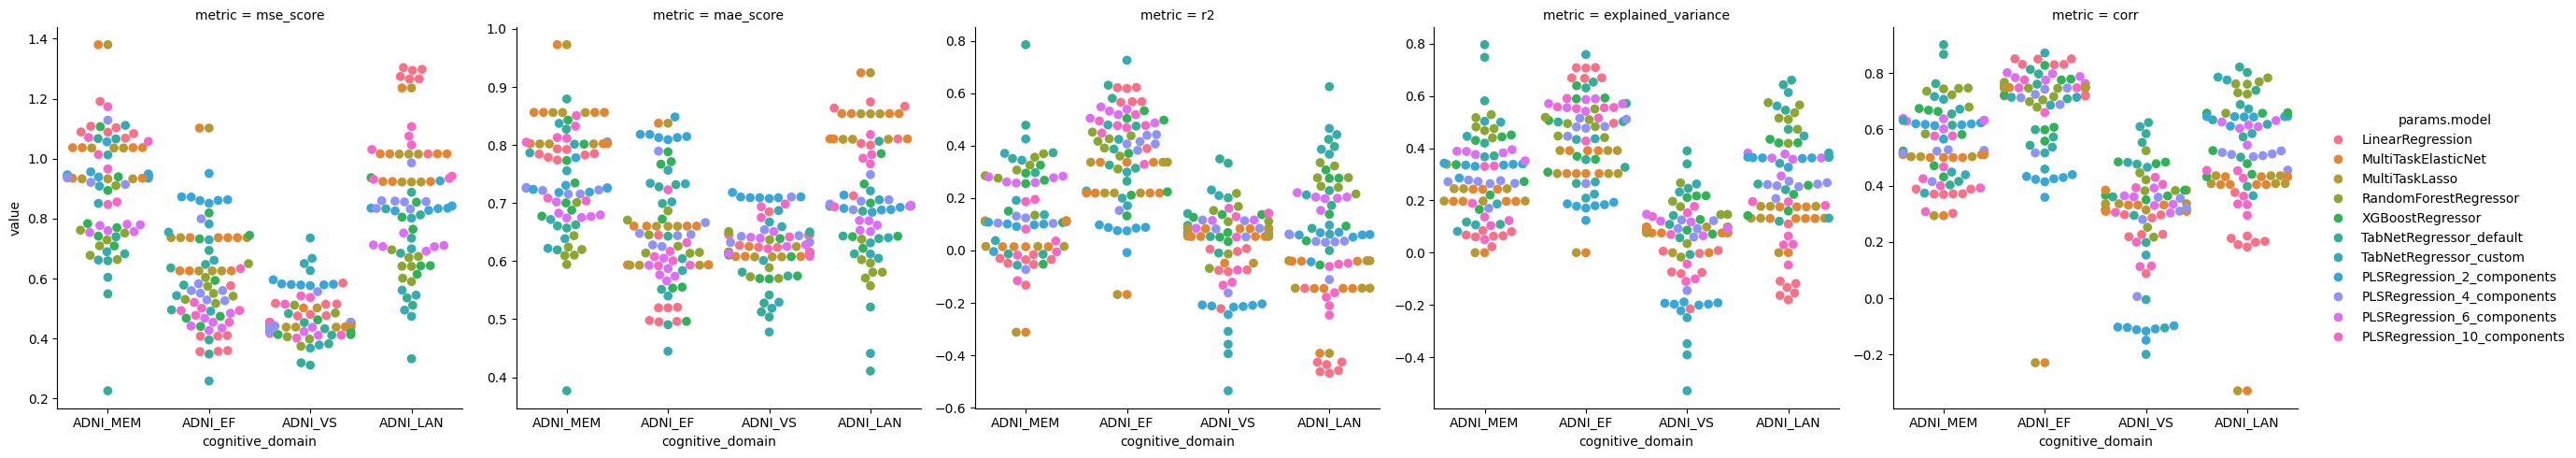

In [ ]:
df_plot_loonona_ajd = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_adj"]
df_plot_loonona_org = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_org"]

sns.catplot(data=df_plot_loonona_ajd, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

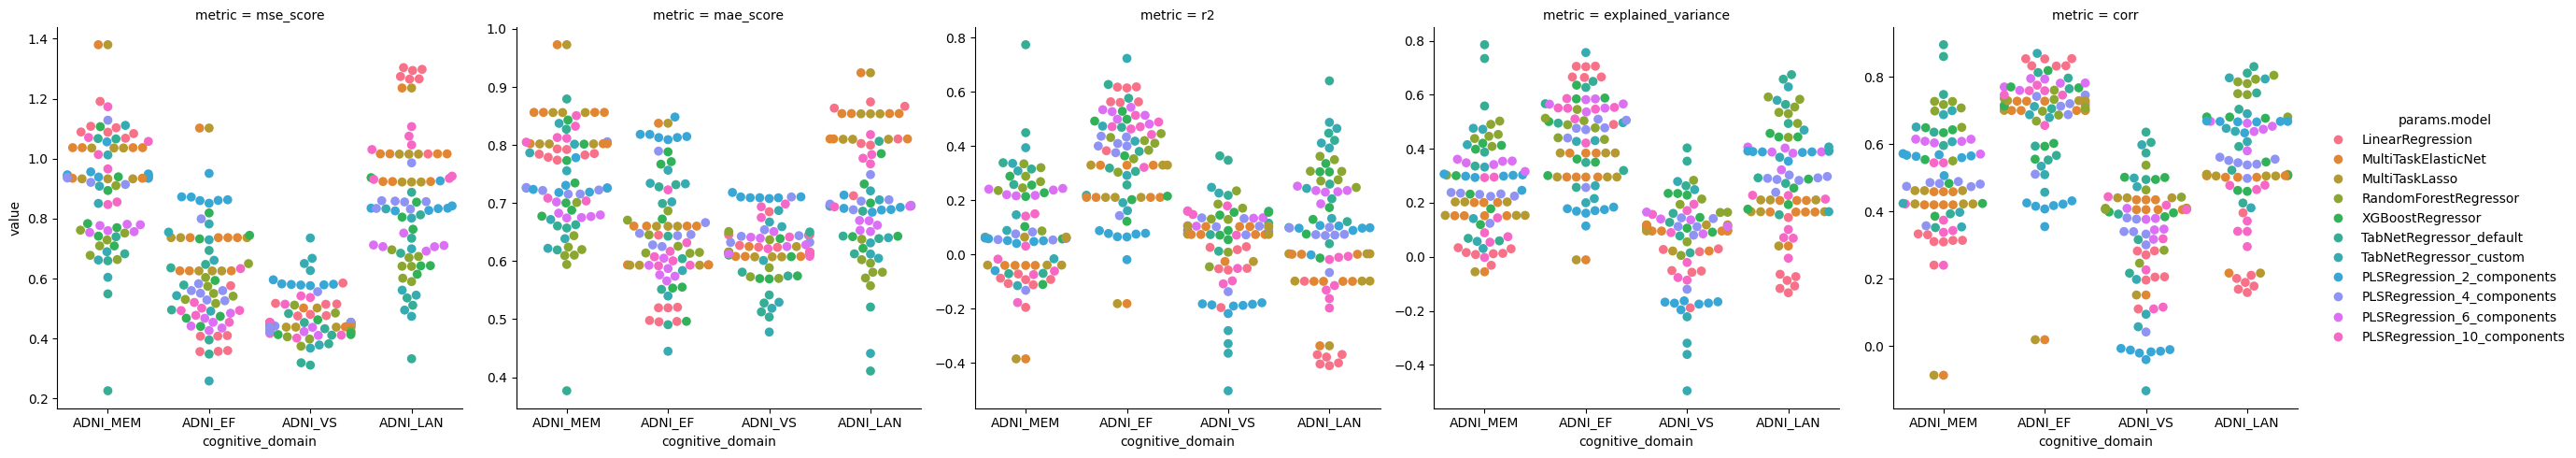

In [ ]:
sns.catplot(data=df_plot_loonona_org, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

In [ ]:
def train_imputer_model(
    df_X_train, df_X_test, df_y_train, df_y_test,
    c_train, c_test,
    ordinal_model, name_ordinal_imputer, 
    continuous_model, name_continuous_imputer, 
    model, name_model, 
    imputer_model=None, name_imputer=None, 
    separate_imputers=True,
    ordinal_features = ['APOE_epsilon2', 'APOE_epsilon3', 'APOE_epsilon4']
): 
    # Define which columns are ordinal and which are continuous
    continuous_features = [col for col in df_X_train.columns if col not in ordinal_features]

    # Check if a general imputer model (like MissForest or MICEForest) is provided
    if imputer_model is not None and name_imputer is not None and not separate_imputers:
        # If `imputer_model` can handle both categorical and continuous data types
        print(f"Using general imputer model: {name_imputer}")

        # Ensure that ordinal columns are marked as categorical
        df_X_train = df_X_train.copy()
        df_X_test = df_X_test.copy()
        
        for col in ordinal_features:
            df_X_train[col] = df_X_train[col].astype("category")
            df_X_test[col] = df_X_test[col].astype("category")

        # Create a pipeline with the general imputer
        pipeline = Pipeline(steps=[
            (name_imputer, imputer_model)
        ])

        # Fit and transform the entire dataset with the general imputer
        pipeline.fit(df_X_train)
        X_train_imputed = pipeline.transform(df_X_train)
        X_test_imputed = pipeline.transform(df_X_test)

        # Convert transformed output back to DataFrame with original column names
        df_X_train_imputed = pd.DataFrame(X_train_imputed, columns=df_X_train.columns)
        df_X_test_imputed = pd.DataFrame(X_test_imputed, columns=df_X_test.columns)

    else:
        # Separate imputers for ordinal and continuous data
        print("Using separate imputers for ordinal and continuous data.")

        df_X_train = df_X_train.copy()
        df_X_test = df_X_test.copy()

        # Continuous Imputation Transformer (Example: SimpleImputer)
        continuous_imputer = Pipeline([
            (name_continuous_imputer, continuous_model),
        ])

        # Ordinal Imputation Transformer (Example: KNN Imputer)
        ordinal_imputer = Pipeline([
            (name_ordinal_imputer, ordinal_model)
        ])

        # Create a ColumnTransformer to apply the appropriate imputer to each type of variable
        preprocessor = ColumnTransformer(
            transformers=[
                ('ordinal', ordinal_imputer, ordinal_features),
                ('continuous', continuous_imputer, continuous_features)
            ],
            remainder='passthrough'
        )

        # Create the pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor)
        ])

         # Separate imputers for ordinal and continuous data

        # Fit and transform, then convert back to DataFrame with original column names

        if df_X_train.isna().any().any():
                
            start = time.time()
            pipeline.fit(df_X_train)
            end = time.time()

            impute_model_time = end - start

            X_train_imputed = pipeline.transform(df_X_train)
            df_X_train_imputed = df_X_train.copy()
            df_X_train_imputed[ordinal_features+continuous_features] = X_train_imputed

        else :
            print("No NaN in train data -> Keep as it is. ")
            df_X_train_imputed = df_X_train
            
            impute_model_time = None

        # Transform the test set
        if df_X_test.isna().any().any(): 
            X_test_imputed = pipeline.transform(df_X_test)
            df_X_test_imputed = df_X_test.copy()
            df_X_test_imputed[ordinal_features+continuous_features] = X_test_imputed
        else : 
            print("No NaN in test data -> Keep as it is. ")
            df_X_test_imputed = df_X_test

    #df_X_train_imputed[ordinal_features] = df_X_train_imputed[ordinal_features].astype("category")
    #df_X_test_imputed[ordinal_features] = df_X_test_imputed[ordinal_features].astype("category")

    # Demographics adjustment for y
    demographic_adjustment_y = DemographicAdjustmentTransformer()
    
    y_train_adjusted = demographic_adjustment_y.fit_transform(df_y_train, c_train)
    y_test_adjusted = demographic_adjustment_y.transform(df_y_test, c_test)

    # Demographics adjustment for X
    demographic_adjustment_X = DemographicAdjustmentTransformer(categorical_columns=ordinal_features)
    X_train_adjusted = demographic_adjustment_X.fit_transform(df_X_train_imputed, c_train)
    X_test_adjusted = demographic_adjustment_X.transform(df_X_test_imputed, c_test)

    # Perform prediction and save variables
    start = time.time()

    if isinstance(model, TabNetRegressor): 
        X_train_adjusted = X_train_adjusted.values
        y_train_adjusted = y_train_adjusted.values

        X_test_adjusted = X_test_adjusted.values
        #y_test_adjusted = y_test_adjusted.values
    
    model.fit(X_train_adjusted, y_train_adjusted) 
    end = time.time()

    predict_model_time = end - start

    y_pred_adjusted = model.predict(X_test_adjusted)

    y_pred_adjusted = pd.DataFrame(y_pred_adjusted, columns=y_test_adjusted.columns)

    # Metrics computed in original space
    y_pred = demographic_adjustment_y.inverse_transform(y_pred_adjusted, c_test)

    params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : X_train_adjusted.shape, 
        "test_shape": X_test_adjusted.shape
    }
    
    if df_X_test.shape[0] != 1: 

        # Metrics computed in adjusted space
        mse_score_adj, mae_score_ajd, r2_adj, explained_variance_adj, corr_adj = compute_all_metrics(y_test_adjusted.values, y_pred_adjusted)

        results_adj = {
            "mse_score": mse_score_adj, 
            "mae_score":mae_score_ajd, 
            "r2":r2_adj, 
            "explained_variance":explained_variance_adj, 
            "corr":corr_adj, 
        }

        mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(df_y_test.values, y_pred)

        results_org = {
            "mse_score": mse_score, 
            "mae_score": mae_score, 
            "r2": r2, 
            "explained_variance": explained_variance, 
            "corr": corr, 
        }

    else : 
        print("Saving predictions in dict!")
        results_adj = {
            "y_pred": y_pred_adjusted.values, 
            "y_test": y_test_adjusted.values,
        }

        results_org = {
            "y_pred": y_pred.values, 
            "y_test": df_y_test.values,
        }


    dict_results = {
        "params": params, 
        "imputation_time": impute_model_time,
        "fitting_time": predict_model_time, 
        "results_adj": results_adj, 
        "results_org": results_org
        }

    return dict_results


In [ ]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

In [ ]:
df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")

In [ ]:
df_X_train = df_X[select_MRIthickness].loc[idx_train]
df_X_test = df_X[select_MRIthickness].loc[idx_test]

df_y_train = df_y.loc[idx_train]
df_y_test = df_y.loc[idx_test]

c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

In [ ]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("NoImputer", KNNImputer(n_neighbors=1)),

]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("NoImputer", SimpleImputer(strategy="most_frequent")),
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("MultiTaskElasticNet", MultiTaskElasticNet()),
    ("MultiTaskLasso", MultiTaskLasso()),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("XGBoostRegressor", XGBoostRegressor()),
    ("TabNetRegressor_default", TabNetModelWrapper()),
    ("TabNetRegressor_custom", TabNetModelWrapper(n_a=32, n_d=32)),
    ("PLSRegression_2_components", PLSRegression(n_components=2)),
    ("PLSRegression_4_components", PLSRegression(n_components=4)),
    ("PLSRegression_10_components", PLSRegression(n_components=10))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: LinearRegression
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskElasticNet
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskLasso
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: RandomForestRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: XGBoostRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_default
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_custom
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_2_components
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_4_components
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_10_components
Combinations of preprocessing and models to test : 10


In [ ]:
# Initialize HDF5 file
results_file = '../pickle/training_2_dict_results.pickle'

with open('../pickle/training_2_dict_results.pickle', "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [ ]:
for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    try: 
    
        # Now you can call your `train_model` function with these components
        dict_results = train_imputer_model(
            df_X_train, df_X_test, df_y_train, df_y_test,
            c_train, c_test,
            ordinal_imputer_instance, name_ordinal_imputer,
            continuous_imputer_instance, name_continuous_imputer,
            model_instance, name_model,
            separate_imputers=True  # Or however you want to specify
        )

    except Exception as e:  

        print(e)
    
        params = {
        "ordinal_imputer": name_ordinal_imputer, 
        "continuous_imputer": name_continuous_imputer, 
        "model": name_model, "train_shape" : df_X_train.shape, 
        "test_shape": df_X_test.shape
    }
        dict_results = {
        "params": params, 
        "imputation_time": None,
        "fitting_time": None, 
        "results_adj": None, 
        "results_org": None
    }
        
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)

    # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
epoch 0  | loss: 3.05202 |  0:00:00s
epoch 1  | loss: 1.65424 |  0:00:00s
epoch 2  | loss: 1.28961 |  0:00:00s
epoch 3  | loss: 1.14827 |  0:00:00s
epoch 4  | loss: 1.03589 |  0:00:00s

In [ ]:
# Store data (serialize)
with open(results_file, 'wb') as handle:
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(results_file, "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [ ]:
df_results_split = missing_results_dict_to_dataframe(all_dict_results, df_y.columns)
df_results_split_radar = df_results_split.melt(id_vars=df_results_split.columns[df_results_split.columns.str.startswith("params")].tolist(), value_vars=df_results_split.columns[df_results_split.columns.str.startswith("results")].tolist())

results_adj.mse_score.ADNI_MEM
results_adj.mse_score.ADNI_EF
results_adj.mse_score.ADNI_VS
results_adj.mse_score.ADNI_LAN
results_adj.mae_score.ADNI_MEM
results_adj.mae_score.ADNI_EF
results_adj.mae_score.ADNI_VS
results_adj.mae_score.ADNI_LAN
results_adj.r2.ADNI_MEM
results_adj.r2.ADNI_EF
results_adj.r2.ADNI_VS
results_adj.r2.ADNI_LAN
results_adj.explained_variance.ADNI_MEM
results_adj.explained_variance.ADNI_EF
results_adj.explained_variance.ADNI_VS
results_adj.explained_variance.ADNI_LAN
results_adj.corr.ADNI_MEM
results_adj.corr.ADNI_EF
results_adj.corr.ADNI_VS
results_adj.corr.ADNI_LAN
results_org.mse_score.ADNI_MEM
results_org.mse_score.ADNI_EF
results_org.mse_score.ADNI_VS
results_org.mse_score.ADNI_LAN
results_org.mae_score.ADNI_MEM
results_org.mae_score.ADNI_EF
results_org.mae_score.ADNI_VS
results_org.mae_score.ADNI_LAN
results_org.r2.ADNI_MEM
results_org.r2.ADNI_EF
results_org.r2.ADNI_VS
results_org.r2.ADNI_LAN
results_org.explained_variance.ADNI_MEM
results_org.explained_va

In [ ]:
df_results_split_radar["variable"] = df_results_split_radar["variable"].apply(lambda x : x.replace("_ajd_", "_"))
df_results_split_radar["result_domain"] = df_results_split_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_split_radar["metric"] = df_results_split_radar["variable"].apply(lambda x: "_".join(x.split(".")[1].split(".")[:2]))
df_results_split_radar["cognitive_domain"] = df_results_split_radar["variable"].apply(lambda x: "".join(x.split(".")[2]))
df_results_split_radar = df_results_split_radar.drop(columns=["variable"])
df_results_split_radar["preprocessing"] =  df_results_split_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)
df_results_split_radar["pipeline"] =  df_results_split_radar[['params.ordinal_imputer', 'params.continuous_imputer', 'params.model']].agg('.'.join, axis=1)

In [ ]:
df_results_split_radar

params.ordinal_imputer params.continuous_imputer  \
0     SimpleImputer_most_frequent                KNNImputer   
1     SimpleImputer_most_frequent                KNNImputer   
2     SimpleImputer_most_frequent                KNNImputer   
3     SimpleImputer_most_frequent                KNNImputer   
4     SimpleImputer_most_frequent                KNNImputer   
...                           ...                       ...   
4235                    NoImputer                 NoImputer   
4236                    NoImputer                 NoImputer   
4237                    NoImputer                 NoImputer   
4238                    NoImputer                 NoImputer   
4239                    NoImputer                 NoImputer   

                     params.model params.train_shape params.test_shape  \
0                LinearRegression        (2882, 261)         (12, 261)   
1             MultiTaskElasticNet        (2882, 261)         (12, 261)   
2                  MultiTaskLasso        (2882, 261)         (12, 261)   
3           RandomForestRegressor        (2882, 261)         (12, 261)   
4                XGBoostRegressor        (2882, 261)         (12, 261)   
...                           ...                ...               ...   
4235      TabNetRegressor_default        (2882, 200)         (12, 200)   
4236       TabNetRegressor_custom        (2882, 200)         (12, 200)   
4237   PLSRegression_2_components        (2882, 200)         (12, 200)   
4238   PLSRegression_4_components        (2882, 200)         (12, 200)   
4239  PLSRegression_10_components        (2882, 200)         (12, 200)   

         value result_domain     metric cognitive_domain  \
0     1.077550   results_adj  mse_score         ADNI_MEM   
1     1.032492   results_adj  mse_score         ADNI_MEM   
2     1.031354   results_adj  mse_score         ADNI_MEM   
3     0.815788   results_adj  mse_score         ADNI_MEM   
4     0.897634   results_adj  mse_score         ADNI_MEM   
...        ...           ...        ...              ...   
4235  0.616612   results_org       corr         ADNI_LAN   
4236  0.596705   results_org       corr         ADNI_LAN   
4237  0.633622   results_org       corr         ADNI_LAN   
4238  0.496479   results_org       corr         ADNI_LAN   
4239  0.456302   results_org       corr         ADNI_LAN   

                               preprocessing  \
0     SimpleImputer_most_frequent.KNNImputer   
1     SimpleImputer_most_frequent.KNNImputer   
2     SimpleImputer_most_frequent.KNNImputer   
3     SimpleImputer_most_frequent.KNNImputer   
4     SimpleImputer_most_frequent.KNNImputer   
...                                      ...   
4235                     NoImputer.NoImputer   
4236                     NoImputer.NoImputer   
4237                     NoImputer.NoImputer   
4238                     NoImputer.NoImputer   
4239                     NoImputer.NoImputer   

                                               pipeline  
0     SimpleImputer_most_frequent.KNNImputer.LinearR...  
1     SimpleImputer_most_frequent.KNNImputer.MultiTa...  
2     SimpleImputer_most_frequent.KNNImputer.MultiTa...  
3     SimpleImputer_most_frequent.KNNImputer.RandomF...  
4     SimpleImputer_most_frequent.KNNImputer.XGBoost...  
...                                                 ...  
4235        NoImputer.NoImputer.TabNetRegressor_default  
4236         NoImputer.NoImputer.TabNetRegressor_custom  
4237     NoImputer.NoImputer.PLSRegression_2_components  
4238     NoImputer.NoImputer.PLSRegression_4_components  
4239    NoImputer.NoImputer.PLSRegression_10_components  

[4240 rows x 11 columns]

In [ ]:
def df_results_radar_to_latex_pretable(df_results_preprocess_radar_, result_domain = "results_adj", scoring_metric="corr", ascending=True): 
        
        df_results_preprocess_to_latex = df_results_preprocess_radar_.drop(columns=["preprocessing", "params.train_shape", "params.test_shape"])

        df = df_results_preprocess_to_latex[df_results_preprocess_to_latex["result_domain"]== result_domain].drop(columns="result_domain")

        df_pivoted = df.pivot_table(index=['params.ordinal_imputer', 'params.continuous_imputer', 'params.model'],
                                    columns=['metric', 'cognitive_domain'],
                                    values='value',
                                    aggfunc='first')

        # Resetting index to flatten the MultiIndex
        df_pivoted.reset_index(inplace=True)
        # Flatten the MultiIndex columns temporarily for filtering
        df_pivoted.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_pivoted.columns]

        # Select columns that start with 'params' or contain 'corr'
        columns_to_keep = [col for col in df_pivoted.columns if col.startswith('params') or scoring_metric in col]

        # Filter the dataframe
        df_filtered = df_pivoted[columns_to_keep]

        # Display the filtered dataframe
        # Add a column for the mean of each row
        # Select only the numeric columns (excluding 'params' columns)
        numeric_columns = df_filtered.select_dtypes(include='number').columns

        # Add a column for the mean of each row (across numeric columns)
        df_filtered['mean'] = df_filtered[numeric_columns].mean(axis=1)

        # Add a column for the standard deviation of each row (across numeric columns)
        df_filtered['std'] = df_filtered[numeric_columns].std(axis=1)

        return df_filtered.sort_values("mean", ascending=ascending)

In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)
df_results_radar_to_latex_pretable(df_results_split_radar, result_domain="results_adj", scoring_metric="corr", ascending=False).dropna()

params.ordinal_imputer_ params.continuous_imputer_  \
74  SimpleImputer_most_frequent               KNNImputer_2   
9                    KNNImputer                 KNNImputer   
42       SimpleImputer_constant                 KNNImputer   
40       SimpleImputer_constant                 KNNImputer   
20                   KNNImputer               KNNImputer_2   
..                          ...                        ...   
26                    NoImputer                  NoImputer   
27                    NoImputer                  NoImputer   
19                   KNNImputer               KNNImputer_2   
62  SimpleImputer_most_frequent                 KNNImputer   
73  SimpleImputer_most_frequent               KNNImputer_2   

                 params.model_  corr_ADNI_EF  corr_ADNI_LAN  corr_ADNI_MEM  \
74     TabNetRegressor_default         0.792          0.774          0.844   
9      TabNetRegressor_default         0.737          0.637          0.766   
42            XGBoostRegressor         0.792          0.622          0.634   
40      TabNetRegressor_custom         0.750          0.700          0.679   
20     TabNetRegressor_default         0.684          0.712          0.759   
..                         ...           ...            ...            ...   
26  PLSRegression_2_components         0.360          0.612          0.567   
27  PLSRegression_4_components         0.515          0.454          0.414   
19      TabNetRegressor_custom         0.047          0.556          0.403   
62      TabNetRegressor_custom         0.345          0.211          0.443   
73      TabNetRegressor_custom         0.304          0.346          0.369   

    corr_ADNI_VS  mean   std  
74         0.603 0.753 0.105  
9          0.723 0.716 0.056  
42         0.598 0.662 0.088  
40         0.515 0.661 0.102  
20         0.487 0.660 0.119  
..           ...   ...   ...  
26        -0.148 0.348 0.348  
27         0.005 0.347 0.232  
19         0.265 0.318 0.216  
62         0.028 0.257 0.180  
73        -0.323 0.174 0.333  

[74 rows x 9 columns]

In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)
df_results_radar_to_latex_pretable(df_results_split_radar, result_domain="results_adj", scoring_metric="mae_score", ascending=True)

params.ordinal_imputer_ params.continuous_imputer_  \
9                    KNNImputer                 KNNImputer   
20                   KNNImputer               KNNImputer_2   
74  SimpleImputer_most_frequent               KNNImputer_2   
40       SimpleImputer_constant                 KNNImputer   
42       SimpleImputer_constant                 KNNImputer   
..                          ...                        ...   
62  SimpleImputer_most_frequent                 KNNImputer   
73  SimpleImputer_most_frequent               KNNImputer_2   
8                    KNNImputer                 KNNImputer   
23                    NoImputer                  NoImputer   
24                    NoImputer                  NoImputer   

              params.model_  mae_score_ADNI_EF  mae_score_ADNI_LAN  \
9   TabNetRegressor_default              0.487               0.685   
20  TabNetRegressor_default              0.598               0.574   
74  TabNetRegressor_default              0.533               0.630   
40   TabNetRegressor_custom              0.636               0.583   
42         XGBoostRegressor              0.564               0.632   
..                      ...                ...                 ...   
62   TabNetRegressor_custom              0.825               0.835   
73   TabNetRegressor_custom              0.783               0.791   
8    TabNetRegressor_custom              0.890               0.738   
23      MultiTaskElasticNet              0.837               0.926   
24           MultiTaskLasso              0.837               0.926   

    mae_score_ADNI_MEM  mae_score_ADNI_VS  mean   std  
9                0.615              0.383 0.543 0.134  
20               0.603              0.536 0.578 0.031  
74               0.662              0.499 0.581 0.077  
40               0.689              0.499 0.602 0.081  
42               0.673              0.540 0.602 0.061  
..                 ...                ...   ...   ...  
62               0.828              0.642 0.782 0.094  
73               0.833              0.755 0.790 0.033  
8                0.769              0.799 0.799 0.066  
23               0.974              0.625 0.840 0.154  
24               0.974              0.625 0.840 0.154  

[76 rows x 9 columns]

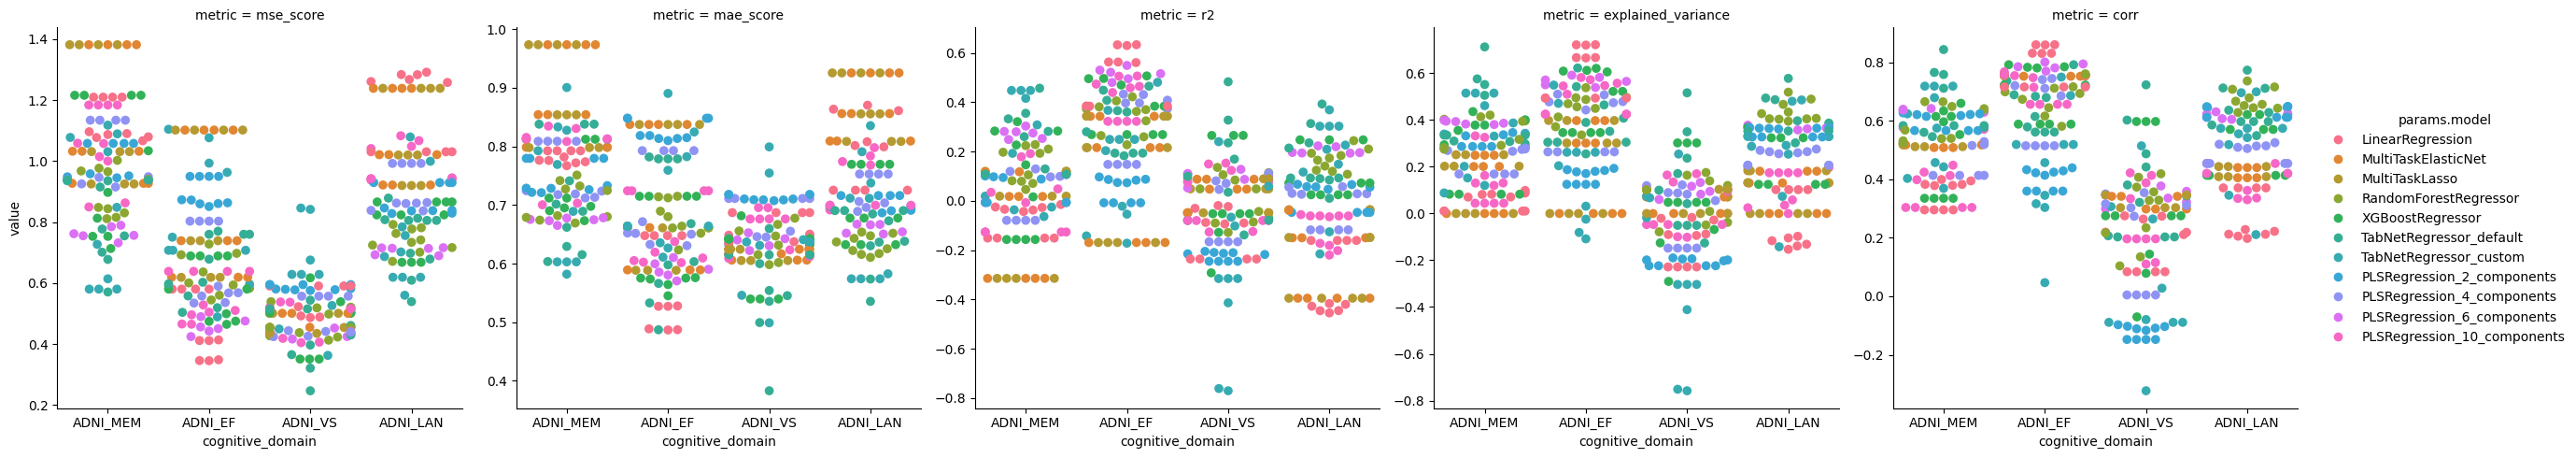

In [ ]:
df_plot_split_ajd = df_results_split_radar[df_results_split_radar['result_domain'] == "results_adj"]
df_plot_split_org = df_results_split_radar[df_results_split_radar['result_domain'] == "results_org"]

sns.catplot(data=df_plot_split_ajd, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

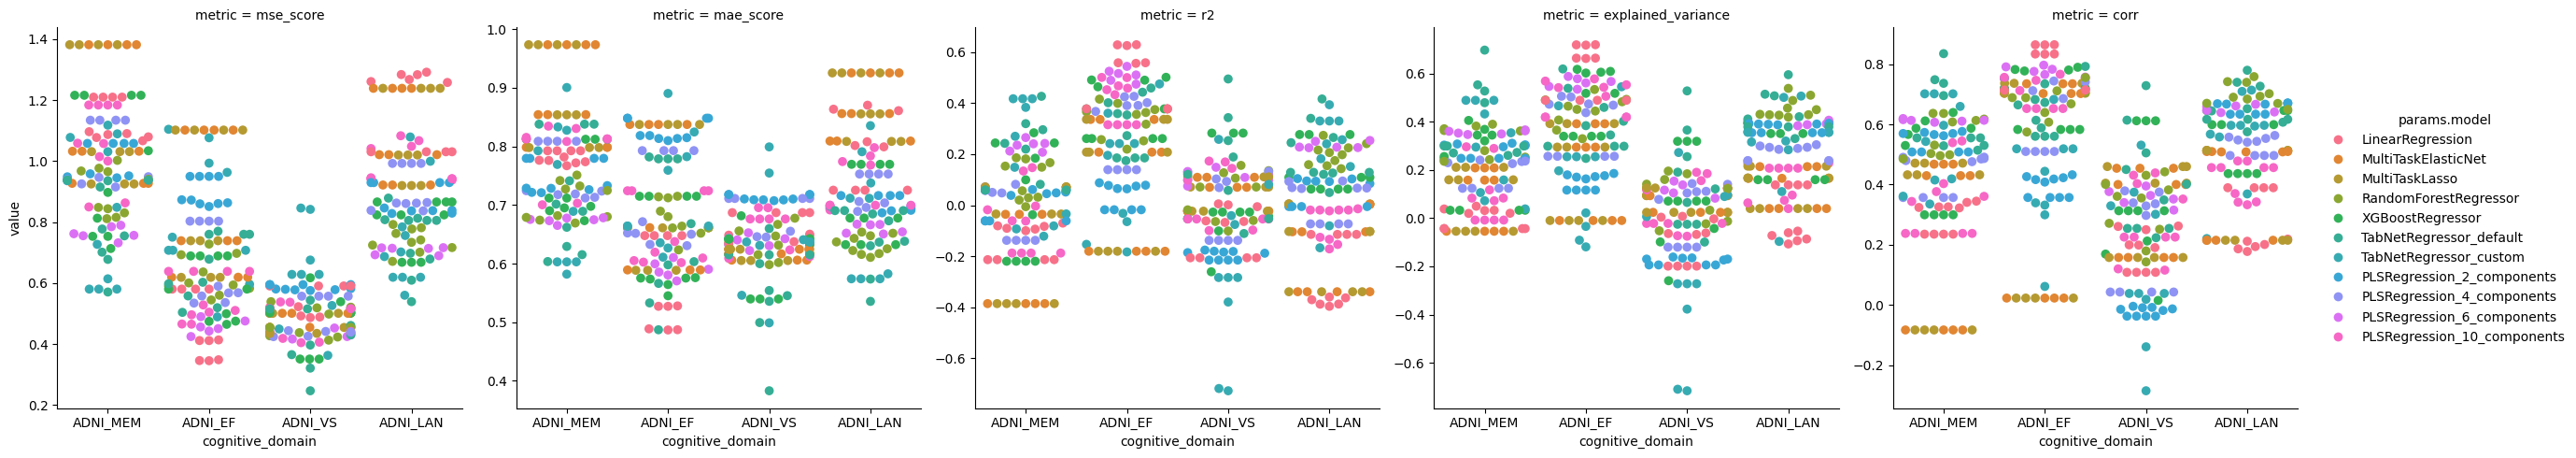

In [ ]:
sns.catplot(data=df_plot_split_org, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

## Option 2 : Leave-one-out without missing values

In [ ]:
idx_train = list(df_X.isna().any(axis=1))
idx_test = list(~df_X.isna().any(axis=1))

set_intersect_rid = set(df_all[idx_train].RID).intersection(set(df_all[idx_test].RID))
intersect_rid_idx = df_all.RID.isin(set_intersect_rid)

for i, bool_test in enumerate(idx_test): 
    if intersect_rid_idx.iloc[i] & bool_test:
        idx_test[i] = False
        idx_train[i] = True

print(sum(idx_test))

print(df_all[idx_test].RID)

df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")

test_indices = [i for i, val in enumerate(idx_test) if val]

12
4610    2002
5511    2374
6329    4167
6400    4176
6421    4179
6634    4215
7007    4292
7052    4300
7242    4349
7822    4453
7981    4489
8061    4505
Name: RID, dtype: int64


In [ ]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("NoImputer", KNNImputer(n_neighbors=1)),
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("NoImputer", SimpleImputer(strategy="most_frequent"))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("MultiTaskElasticNet", MultiTaskElasticNet()),
    ("MultiTaskLasso", MultiTaskLasso()),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("XGBoostRegressor", XGBoostRegressor()),
    ("TabNetRegressor_default", TabNetModelWrapper()),
    ("TabNetRegressor_custom", TabNetModelWrapper(n_a=32, n_d=32)),
    ("PLSRegression_2_components", PLSRegression(n_components=2)),
    ("PLSRegression_4_components", PLSRegression(n_components=4)),
    ("PLSRegression_10_components", PLSRegression(n_components=10))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: LinearRegression
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskElasticNet
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskLasso
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: RandomForestRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: XGBoostRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_default
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_custom
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_2_components
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_4_components
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_10_components
Combinations of preprocessing and models to test : 10


In [ ]:
results_file = '..pickle//training_3_loonona_dict_results.pickle'

with open('..pickle//training_3_loonona_dict_results.pickle', "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [ ]:
all_dict_results

[{'params': {'ordinal_imputer': 'SimpleImputer_most_frequent',
   'continuous_imputer': 'KNNImputer',
   'model': 'LinearRegression',
   'train_shape': [2882, 261],
   'test_shape': [12, 261]},
  'imputation_time': [3.6435670852661133,
   3.529909372329712,
   3.6744284629821777,
   3.473607063293457,
   3.591614007949829,
   3.5121705532073975,
   3.590299606323242,
   3.4694058895111084,
   3.6295206546783447,
   3.511981964111328,
   3.5426716804504395,
   3.460174322128296],
  'fitting_time': [0.0806281566619873,
   0.07628393173217773,
   0.09688425064086914,
   0.09959864616394043,
   0.07928800582885742,
   0.08276629447937012,
   0.08099508285522461,
   0.09943294525146484,
   0.09560346603393555,
   0.07767772674560547,
   0.07803869247436523,
   0.07772493362426758],
  'results_adj': [{'y_pred': array([[0.53845331, 1.04171325, 0.63561356, 0.09622276]]),
    'y_test': array([[2.12343013, 1.80472964, 0.83287438, 1.60856134]])},
   {'y_pred': array([[-0.01849589,  0.02603175, -0

In [ ]:
for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    params = {
            "ordinal_imputer": name_ordinal_imputer, 
            "continuous_imputer": name_continuous_imputer, 
            "model": name_model, "train_shape" : df_X_train.shape, 
            "test_shape": df_X_test.shape
        }
    
    dict_results = {
            "params": params, 
            "imputation_time": [],
            "fitting_time": [], 
            "results_adj": [], 
            "results_org": []
        }

    for test_nloc in test_indices: 

        idx_train = [True for i in range(df_X.shape[0])]
        idx_test = [False for i in range(df_X.shape[0])]

        idx_test[test_nloc] = True
        idx_train[test_nloc] = False

        df_X_train = df_X[select["MRIth"]].loc[idx_train]
        df_X_test = df_X[select["MRIth"]].loc[idx_test]

        df_y_train = df_y.loc[idx_train]
        df_y_test = df_y.loc[idx_test]

        c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
        c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

        try: 
        
            # Now you can call your `train_model` function with these components
            fold_dict_results = train_imputer_model(
                df_X_train, df_X_test, df_y_train, df_y_test,
                c_train, c_test,
                ordinal_imputer_instance, name_ordinal_imputer,
                continuous_imputer_instance, name_continuous_imputer,
                model_instance, name_model,
                separate_imputers=True  # Or however you want to specify
            )
            
            dict_results["imputation_time"].append(fold_dict_results["imputation_time"]) 
            dict_results["fitting_time"].append(fold_dict_results["fitting_time"])  
            dict_results["results_adj"].append(fold_dict_results["results_adj"])  
            dict_results["results_org"].append(fold_dict_results["results_org"])  

        except Exception as e:  

            print(e)
            
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)

    # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Saving predictions in dict!
Using separate imputers for ordinal and continuous data.
No NaN in train data -> Keep as it is. 
No NaN in test data -> Keep as it is. 
Saving predictions in dict!
Using separate i

In [ ]:
len(all_dict_results)

43

In [ ]:
# Store data (serialize)
with open(results_file, 'wb') as handle:
    pickle.dump(all_dict_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('..pickle//training_3_loonona_dict_results.pickle', "rb") as input_file:
    dict_results_loo_nona = pickle.load(input_file)

In [ ]:
df_results_nona = pd.json_normalize(dict_results_loo_nona)

In [ ]:
metrics = ["mse_score", "mae_score", "r2", "explained_variance", "corr"]
results = ["results_adj", "results_org"]

df_results_nona = pd.json_normalize(dict_results_loo_nona)

def extract_metric(row, metric): 

    y_test = np.concatenate([temp_dict["y_test"] for temp_dict in row])
    y_pred = np.concatenate([temp_dict["y_pred"] for temp_dict in row])

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(y_test=y_test, y_pred=y_pred)

    output = None

    if metric=="mse_score": 
        output=mse_score
    elif metric=="mae_score": 
        output=mae_score
    elif metric=="r2": 
        output=r2        
    elif metric=="explained_variance": 
        output=explained_variance
    elif metric=="corr": 
        output=corr   

    return list(output.T)


In [ ]:
for metric in metrics: 
    df_results_nona[f"results_adj.{metric}"] = df_results_nona["results_adj"].apply(extract_metric, metric=metric)
    df_results_nona[f"results_org.{metric}"] = df_results_nona["results_org"].apply(extract_metric, metric=metric)

In [ ]:
for results in ["results_adj", "results_org"]: 
    for metric in metrics: 
        new_cols = list(f"{results}.{metric}." +df_y.columns) 
        new_cols_to_add = df_results_nona[f"{results}.{metric}"].apply(pd.Series, index=new_cols)

        df_results_nona = pd.concat([df_results_nona, new_cols_to_add], axis=1)

In [ ]:
df_results_nona.columns

Index(['imputation_time', 'fitting_time', 'results_adj', 'results_org',
       'params.ordinal_imputer', 'params.continuous_imputer', 'params.model',
       'params.train_shape', 'params.test_shape', 'results_adj.mse_score',
       'results_org.mse_score', 'results_adj.mae_score',
       'results_org.mae_score', 'results_adj.r2', 'results_org.r2',
       'results_adj.explained_variance', 'results_org.explained_variance',
       'results_adj.corr', 'results_org.corr',
       'results_adj.mse_score.ADNI_MEM', 'results_adj.mse_score.ADNI_EF',
       'results_adj.mse_score.ADNI_VS', 'results_adj.mse_score.ADNI_LAN',
       'results_adj.mae_score.ADNI_MEM', 'results_adj.mae_score.ADNI_EF',
       'results_adj.mae_score.ADNI_VS', 'results_adj.mae_score.ADNI_LAN',
       'results_adj.r2.ADNI_MEM', 'results_adj.r2.ADNI_EF',
       'results_adj.r2.ADNI_VS', 'results_adj.r2.ADNI_LAN',
       'results_adj.explained_variance.ADNI_MEM',
       'results_adj.explained_variance.ADNI_EF',
       'resul

In [ ]:
df_results_loonona_radar = df_results_nona.melt(id_vars=df_results_nona.columns[df_results_nona.columns.str.startswith("params")].tolist(), value_vars=df_results_nona.columns[df_results_nona.columns.str.contains("ADNI")].tolist())
df_results_loonona_radar["result_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_loonona_radar["metric"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[1])

In [ ]:
df_results_loonona_radar["cognitive_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[2])
df_results_loonona_radar = df_results_loonona_radar.drop(columns=["variable"])
df_results_loonona_radar["preprocessing"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)

In [ ]:
df_results_loonona_radar["pipeline"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer', 'params.model']].agg('.'.join, axis=1)

In [ ]:
df_results_loonona_radar

params.ordinal_imputer params.continuous_imputer  \
0     SimpleImputer_most_frequent                KNNImputer   
1     SimpleImputer_most_frequent                KNNImputer   
2     SimpleImputer_most_frequent                KNNImputer   
3     SimpleImputer_most_frequent                KNNImputer   
4     SimpleImputer_most_frequent                KNNImputer   
...                           ...                       ...   
1715                    NoImputer                 NoImputer   
1716                    NoImputer                 NoImputer   
1717                    NoImputer                 NoImputer   
1718                    NoImputer                 NoImputer   
1719                    NoImputer                 NoImputer   

                     params.model params.train_shape params.test_shape  value  \
0                LinearRegression        [2882, 261]         [12, 261]  1.088   
1             MultiTaskElasticNet        [2893, 261]          [1, 261]  1.037   
2                  MultiTaskLasso        [2893, 261]          [1, 261]  1.036   
3           RandomForestRegressor        [2893, 261]          [1, 261]  0.762   
4                XGBoostRegressor        [2893, 261]          [1, 261]  0.894   
...                           ...                ...               ...    ...   
1715      TabNetRegressor_default        (2893, 200)          (1, 200)  0.522   
1716       TabNetRegressor_custom        (2893, 200)          (1, 200)  0.410   
1717   PLSRegression_2_components        (2893, 200)          (1, 200)  0.633   
1718   PLSRegression_4_components        (2893, 200)          (1, 200)  0.498   
1719  PLSRegression_10_components        (2893, 200)          (1, 200)  0.465   

     result_domain     metric cognitive_domain  \
0      results_adj  mse_score         ADNI_MEM   
1      results_adj  mse_score         ADNI_MEM   
2      results_adj  mse_score         ADNI_MEM   
3      results_adj  mse_score         ADNI_MEM   
4      results_adj  mse_score         ADNI_MEM   
...            ...        ...              ...   
1715   results_org       corr         ADNI_LAN   
1716   results_org       corr         ADNI_LAN   
1717   results_org       corr         ADNI_LAN   
1718   results_org       corr         ADNI_LAN   
1719   results_org       corr         ADNI_LAN   

                               preprocessing  \
0     SimpleImputer_most_frequent.KNNImputer   
1     SimpleImputer_most_frequent.KNNImputer   
2     SimpleImputer_most_frequent.KNNImputer   
3     SimpleImputer_most_frequent.KNNImputer   
4     SimpleImputer_most_frequent.KNNImputer   
...                                      ...   
1715                     NoImputer.NoImputer   
1716                     NoImputer.NoImputer   
1717                     NoImputer.NoImputer   
1718                     NoImputer.NoImputer   
1719                     NoImputer.NoImputer   

                                               pipeline  
0     SimpleImputer_most_frequent.KNNImputer.LinearR...  
1     SimpleImputer_most_frequent.KNNImputer.MultiTa...  
2     SimpleImputer_most_frequent.KNNImputer.MultiTa...  
3     SimpleImputer_most_frequent.KNNImputer.RandomF...  
4     SimpleImputer_most_frequent.KNNImputer.XGBoost...  
...                                                 ...  
1715        NoImputer.NoImputer.TabNetRegressor_default  
1716         NoImputer.NoImputer.TabNetRegressor_custom  
1717     NoImputer.NoImputer.PLSRegression_2_components  
1718     NoImputer.NoImputer.PLSRegression_4_components  
1719    NoImputer.NoImputer.PLSRegression_10_components  

[1720 rows x 11 columns]

In [ ]:
df_results_radar_to_latex_pretable(df_results_loonona_radar, result_domain="results_adj", scoring_metric="corr", ascending=False)

params.ordinal_imputer_ params.continuous_imputer_  \
30       SimpleImputer_constant                 KNNImputer   
9                    KNNImputer                 KNNImputer   
40  SimpleImputer_most_frequent                 KNNImputer   
39  SimpleImputer_most_frequent                 KNNImputer   
7                    KNNImputer                 KNNImputer   
28       SimpleImputer_constant                 KNNImputer   
27       SimpleImputer_constant                 KNNImputer   
38  SimpleImputer_most_frequent                 KNNImputer   
8                    KNNImputer                 KNNImputer   
6                    KNNImputer                 KNNImputer   
41  SimpleImputer_most_frequent                 KNNImputer   
17                    NoImputer                  NoImputer   
31       SimpleImputer_constant                 KNNImputer   
10                   KNNImputer                 KNNImputer   
37  SimpleImputer_most_frequent                 KNNImputer   
42  SimpleImputer_most_frequent                 KNNImputer   
5                    KNNImputer                 KNNImputer   
20                    NoImputer                  NoImputer   
26       SimpleImputer_constant                 KNNImputer   
34  SimpleImputer_most_frequent                 KNNImputer   
23       SimpleImputer_constant                 KNNImputer   
2                    KNNImputer                 KNNImputer   
33  SimpleImputer_most_frequent                 KNNImputer   
1                    KNNImputer                 KNNImputer   
22       SimpleImputer_constant                 KNNImputer   
35  SimpleImputer_most_frequent                 KNNImputer   
3                    KNNImputer                 KNNImputer   
24       SimpleImputer_constant                 KNNImputer   
29       SimpleImputer_constant                 KNNImputer   
19                    NoImputer                  NoImputer   
32  SimpleImputer_most_frequent                 KNNImputer   
0                    KNNImputer                 KNNImputer   
21       SimpleImputer_constant                 KNNImputer   
14                    NoImputer                  NoImputer   
4                    KNNImputer                 KNNImputer   
36  SimpleImputer_most_frequent                 KNNImputer   
25       SimpleImputer_constant                 KNNImputer   
11                    NoImputer                  NoImputer   
16                    NoImputer                  NoImputer   
15                    NoImputer                  NoImputer   
18                    NoImputer                  NoImputer   
13                    NoImputer                  NoImputer   
12                    NoImputer                  NoImputer   

                  params.model_  corr_ADNI_EF  corr_ADNI_LAN  corr_ADNI_MEM  \
30      TabNetRegressor_default         0.797          0.802          0.901   
9       TabNetRegressor_default         0.709          0.739          0.763   
40       TabNetRegressor_custom         0.872          0.775          0.672   
39        RandomForestRegressor         0.746          0.760          0.723   
7         RandomForestRegressor         0.699          0.725          0.736   
28        RandomForestRegressor         0.705          0.657          0.679   
27   PLSRegression_6_components         0.788          0.615          0.629   
38   PLSRegression_6_components         0.775          0.632          0.638   
8        TabNetRegressor_custom         0.714          0.786          0.717   
6    PLSRegression_6_components         0.764          0.626          0.632   
41      TabNetRegressor_default         0.543          0.688          0.655   
17        RandomForestRegressor         0.679          0.730          0.584   
31             XGBoostRegressor         0.827          0.440          0.582   
10             XGBoostRegressor         0.779          0.478          0.471   
37   PLSRegression_4_components         0.724          0.523          0.528   
42             

In [ ]:
df_results_radar_to_latex_pretable(df_results_loonona_radar, result_domain="results_adj", scoring_metric="mae_score", ascending=True)

params.ordinal_imputer_ params.continuous_imputer_  \
30       SimpleImputer_constant                 KNNImputer   
40  SimpleImputer_most_frequent                 KNNImputer   
9                    KNNImputer                 KNNImputer   
39  SimpleImputer_most_frequent                 KNNImputer   
8                    KNNImputer                 KNNImputer   
41  SimpleImputer_most_frequent                 KNNImputer   
28       SimpleImputer_constant                 KNNImputer   
7                    KNNImputer                 KNNImputer   
27       SimpleImputer_constant                 KNNImputer   
38  SimpleImputer_most_frequent                 KNNImputer   
6                    KNNImputer                 KNNImputer   
17                    NoImputer                  NoImputer   
31       SimpleImputer_constant                 KNNImputer   
10                   KNNImputer                 KNNImputer   
42  SimpleImputer_most_frequent                 KNNImputer   
35  SimpleImputer_most_frequent                 KNNImputer   
3                    KNNImputer                 KNNImputer   
37  SimpleImputer_most_frequent                 KNNImputer   
5                    KNNImputer                 KNNImputer   
26       SimpleImputer_constant                 KNNImputer   
32  SimpleImputer_most_frequent                 KNNImputer   
0                    KNNImputer                 KNNImputer   
21       SimpleImputer_constant                 KNNImputer   
29       SimpleImputer_constant                 KNNImputer   
11                    NoImputer                  NoImputer   
24       SimpleImputer_constant                 KNNImputer   
18                    NoImputer                  NoImputer   
20                    NoImputer                  NoImputer   
19                    NoImputer                  NoImputer   
14                    NoImputer                  NoImputer   
4                    KNNImputer                 KNNImputer   
25       SimpleImputer_constant                 KNNImputer   
36  SimpleImputer_most_frequent                 KNNImputer   
23       SimpleImputer_constant                 KNNImputer   
2                    KNNImputer                 KNNImputer   
34  SimpleImputer_most_frequent                 KNNImputer   
1                    KNNImputer                 KNNImputer   
22       SimpleImputer_constant                 KNNImputer   
33  SimpleImputer_most_frequent                 KNNImputer   
16                    NoImputer                  NoImputer   
15                    NoImputer                  NoImputer   
12                    NoImputer                  NoImputer   
13                    NoImputer                  NoImputer   

                  params.model_  mae_score_ADNI_EF  mae_score_ADNI_LAN  \
30      TabNetRegressor_default              0.490               0.411   
40       TabNetRegressor_custom              0.445               0.441   
9       TabNetRegressor_default              0.604               0.613   
39        RandomForestRegressor              0.615               0.571   
8        TabNetRegressor_custom              0.540               0.605   
41      TabNetRegressor_default              0.732               0.521   
28        RandomForestRegressor              0.626               0.638   
7         RandomForestRegressor              0.671               0.603   
27   PLSRegression_6_components              0.576               0.662   
38   PLSRegression_6_components              0.593               0.653   
6    PLSRegression_6_components              0.605               0.651   
17        RandomForestRegressor              0.687               0.581   
31             XGBoostRegressor              0.496               0.785   
10             XGBoostRegressor              0.554               0.696   
42             XGBoostRegressor              0.555               0.733   
35  PLSRegression_10_components              0.592               0.696   
3   PLSRegression_10_

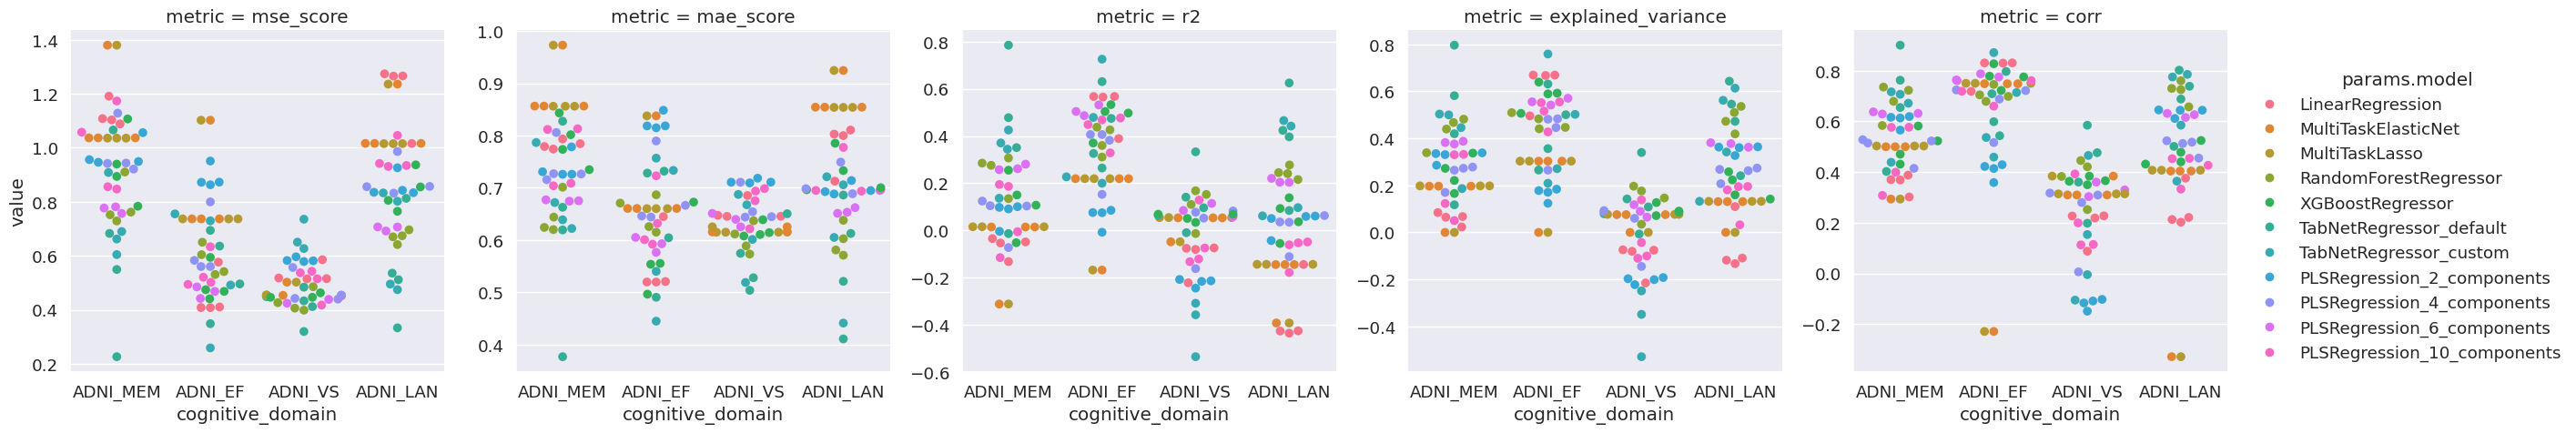

In [ ]:
df_plot_loonona_ajd = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_adj"]
df_plot_loonona_org = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_org"]

sns.catplot(data=df_plot_loonona_ajd, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

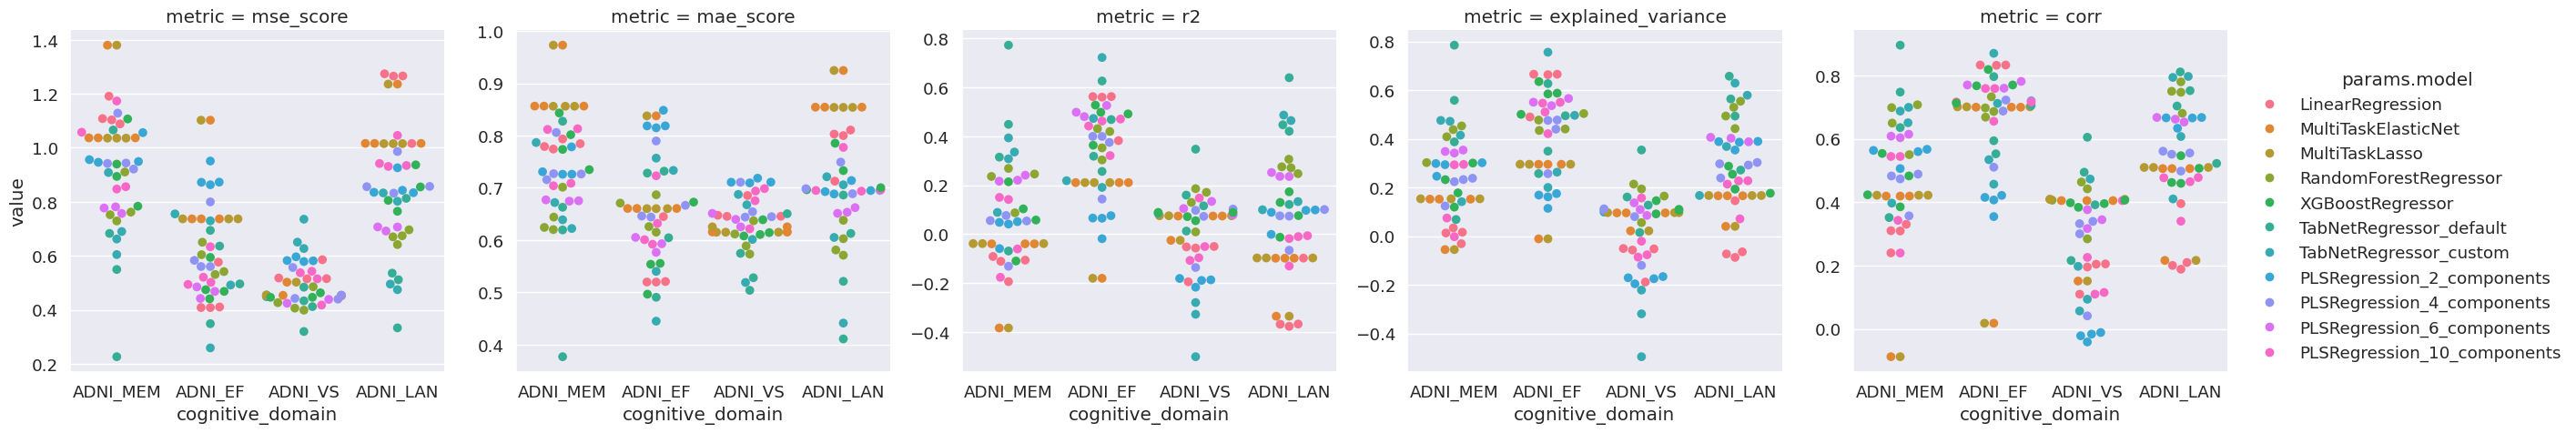

In [ ]:
sns.catplot(data=df_plot_loonona_org, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

## Option 3 : Leave-one-out with missing values

In [ ]:
idx_na = list(df_X.isna().any(axis=1))
idx_nona = list(~df_X.isna().any(axis=1))

# Identify unique RIDs for rows with and without missing data
rid_na = df_all.loc[idx_na, "RID"].unique()
rid_nona = df_all.loc[idx_nona, "RID"].unique()

# Identify RIDs eligible for test set (not in train set)
eligible_rid_na = np.setdiff1d(rid_na, rid_nona)

df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]] = df_X[["APOE_epsilon2", "APOE_epsilon3", "APOE_epsilon4"]].astype("category")


single_measurement_rids = (
    df_all[df_all["RID"].isin(eligible_rid_na)]
    .groupby("RID")
    .filter(lambda x: len(x) == 1)
    .RID.unique()
)

test_rids = np.random.choice(single_measurement_rids, size=20, replace=False)

# Create boolean mask for the test set
idx_test = df_all["RID"].isin(test_rids)

# Create boolean mask for the train set (all not in test)
idx_train = ~idx_test

print(idx_test.sum())

20


In [ ]:
idx_test

11      False
12      False
13      False
17      False
19      False
        ...  
9562    False
9573    False
9595    False
9611    False
9615    False
Name: RID, Length: 2894, dtype: bool

In [ ]:
random_state=42
n_imputation_iter = 10

# Define hyperparameters
gain_parameters = {
    'hint_rate': 0.9,
    'alpha': 100,
    'iterations': 1000
}

# Continuous Imputer List (list of tuples with unique strings and corresponding instances)
continuous_imputer_list = [
    ("NoImputer", KNNImputer(n_neighbors=1)),
]

# Ordinal Imputer List (list of tuples with unique strings and corresponding instances)
ordinal_imputer_list = [
    ("NoImputer", SimpleImputer(strategy="most_frequent"))
]

# Predictive Models List (list of tuples with unique strings and corresponding instances)
predictive_models_list = [
    ("LinearRegression", LinearRegression()),
    ("MultiTaskElasticNet", MultiTaskElasticNet()),
    ("MultiTaskLasso", MultiTaskLasso()),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("XGBoostRegressor", XGBoostRegressor()),
    ("TabNetRegressor_default", TabNetModelWrapper()),
    ("TabNetRegressor_custom", TabNetModelWrapper(n_a=32, n_d=32)),
    ("PLSRegression_2_components", PLSRegression(n_components=2)),
    ("PLSRegression_4_components", PLSRegression(n_components=4)),
    ("PLSRegression_10_components", PLSRegression(n_components=10))
]

# Generate all combinations
combinations = list(product(continuous_imputer_list, ordinal_imputer_list, predictive_models_list))

# Display all combinations
for continuous_imputer, ordinal_imputer, model in combinations:
    print(f"Continuous Imputer: {continuous_imputer[0]}, Ordinal Imputer: {ordinal_imputer[0]}, Model: {model[0]}")

print(f"Combinations of preprocessing and models to test : {len(combinations)}")

Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: LinearRegression
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskElasticNet
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: MultiTaskLasso
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: RandomForestRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: XGBoostRegressor
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_default
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: TabNetRegressor_custom
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_2_components
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_4_components
Continuous Imputer: NoImputer, Ordinal Imputer: NoImputer, Model: PLSRegression_10_components
Combinations of preprocessing and models to test : 10


In [ ]:
test_indices = [i for i, val in enumerate(idx_test) if val]

In [ ]:
results_file = '../pickle/training_3_loonona_dict_results.pickle'

with open(results_file, "rb") as input_file:
    all_dict_results = pickle.load(input_file)

In [ ]:
test_rids = all_dict_results[0]["params"]["test_rid"]

# Create boolean mask for the test set
idx_test = df_all["RID"].isin(test_rids)

# Create boolean mask for the train set (all not in test)
idx_train = ~idx_test

print(idx_test.sum())

test_indices = [i for i, val in enumerate(idx_test) if val]

20


In [ ]:
all([results["params"]["test_rid"] == test_rids for results in all_dict_results])

False

In [ ]:
len(all_dict_results)

43

In [ ]:
test_indices

[12,
 97,
 128,
 862,
 1081,
 1183,
 1335,
 1343,
 1525,
 1706,
 1972,
 2061,
 2269,
 2286,
 2355,
 2449,
 2557,
 2586,
 2679,
 2880]

In [ ]:
list(df_all.iloc[test_indices].values)

[array([15, 'm06', 'ADNI1', 'ADNI1', '2006-04-18', '2006-04-18', 1.111,
        1.149, 0.706, 1.983, 'ADNI1', '100_S_0015', 'm06', 1.0, 1.0, 1.0,
        1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,
        1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 17.0, 5.0, 7.0, 11.0,
        9.0, 8.0, 7.0, 6.0, 9.0, 6.0, 24.0, 12.0, 26.0, 37.0, 66.0, 15.0,
        29.0, 6.0, 13.0, 2.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 0.0,
        'Processed', 'ADNI1/GO Month 6', 1.5, 'MPR; ; N3; Scaled',
        '2006-04-18', 3621.0, 13657.0, '100_S_0015', 100.0, 'CN', 80.8,
        1.0, 18.0, 'Not Hisp/Latino', 'White', 'Married', 1.0, nan, nan,
        nan, nan, nan, nan, 0.0, 3.0, 5.0, 2.0, 30.0, 40.0, 3.0, 2.0, 25.0,
        0.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, '1.5 Tesla MRI',
        'Cross-Sectional FreeSurfer (FreeSurfer Version 4.3)', 33049.0,
        32392.0,

In [ ]:
idx_train.sum()

2874

In [ ]:
idx_test

11      False
12      False
13      False
17      False
19      False
        ...  
9562    False
9573    False
9595    False
9611    False
9615    False
Name: RID, Length: 2894, dtype: bool

In [ ]:
for continuous_imputer, ordinal_imputer, model in combinations:
    name_continuous_imputer, continuous_imputer_instance = continuous_imputer
    name_ordinal_imputer, ordinal_imputer_instance = ordinal_imputer
    name_model, model_instance = model

    params = {
            "ordinal_imputer": name_ordinal_imputer, 
            "continuous_imputer": name_continuous_imputer, 
            "model": name_model, "train_shape" : df_X_train.shape, 
            "test_shape": df_X_test.shape,
            "test_rid": list(df_all.iloc[test_indices])
        }

    # Define the subset of keys you care about
    keys_to_check = ['ordinal_imputer', 'continuous_imputer', 'model']  # or whatever subset you want

    # Check if a result in all_dict_results has the same values for just those keys
    if any(all(result['params'].get(k) == params.get(k) for k in keys_to_check) for result in all_dict_results):
        print(f"Skipping existing combination (subset match): {[params[k] for k in keys_to_check]}")
        continue
    
    dict_results = {
            "params": params, 
            "imputation_time": [],
            "fitting_time": [], 
            "results_adj": [], 
            "results_org": []
        }

    for test_nloc in test_indices: 

        idx_train = [True for i in range(df_X.shape[0])]
        idx_test = [False for i in range(df_X.shape[0])]

        idx_test[test_nloc] = True
        idx_train[test_nloc] = False

        df_X_train = df_X[select_MRIthickness].loc[idx_train]
        df_X_test = df_X[select_MRIthickness].loc[idx_test]

        df_y_train = df_y.loc[idx_train]
        df_y_test = df_y.loc[idx_test]

        c_train = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_train]
        c_test = df_all[["AGE", "PTGENDER", "PTEDUCAT"]].iloc[idx_test]

        try: 
        
            # Now you can call your `train_model` function with these components
            fold_dict_results = train_imputer_model(
                df_X_train, df_X_test, df_y_train, df_y_test,
                c_train, c_test,
                ordinal_imputer_instance, name_ordinal_imputer,
                continuous_imputer_instance, name_continuous_imputer,
                model_instance, name_model,
                separate_imputers=True  # Or however you want to specify
            )

            dict_results["imputation_time"].append(fold_dict_results["imputation_time"])  
            dict_results["fitting_time"].append(fold_dict_results["fitting_time"])  
            dict_results["results_adj"].append(fold_dict_results["results_adj"])  
            dict_results["results_org"].append(fold_dict_results["results_org"])    

        except Exception as e:  

            print(e)
            
    # Optionally keep the all_dict_results list updated
    all_dict_results.append(dict_results)
    
    # Save the updated results back to the pickle file
    with open(results_file, 'wb') as f:
        pickle.dump(all_dict_results, f)


Skipping existing combination (subset match): ['NoImputer', 'NoImputer', 'LinearRegression']
Skipping existing combination (subset match): ['NoImputer', 'NoImputer', 'MultiTaskElasticNet']
Skipping existing combination (subset match): ['NoImputer', 'NoImputer', 'MultiTaskLasso']
Skipping existing combination (subset match): ['NoImputer', 'NoImputer', 'RandomForestRegressor']
Skipping existing combination (subset match): ['NoImputer', 'NoImputer', 'XGBoostRegressor']
Skipping existing combination (subset match): ['NoImputer', 'NoImputer', 'TabNetRegressor_default']
Skipping existing combination (subset match): ['NoImputer', 'NoImputer', 'TabNetRegressor_custom']
Skipping existing combination (subset match): ['NoImputer', 'NoImputer', 'PLSRegression_2_components']
Skipping existing combination (subset match): ['NoImputer', 'NoImputer', 'PLSRegression_4_components']
Skipping existing combination (subset match): ['NoImputer', 'NoImputer', 'PLSRegression_10_components']


In [ ]:
with open('../pickle/training_3_loonona_dict_results.pickle', "rb") as input_file:
    dict_results_loo_nona = pickle.load(input_file)

dict_results_loo_nona_copy_failed = dict_results_loo_nona

In [ ]:
dict_results_loo_nona_copy_failed

[{'params': {'ordinal_imputer': 'SimpleImputer_most_frequent',
   'continuous_imputer': 'KNNImputer',
   'model': 'LinearRegression',
   'train_shape': (2893, 261),
   'test_shape': (1, 261),
   'test_rid': [15,
    69,
    88,
    680,
    886,
    957,
    1099,
    1116,
    1276,
    2073,
    4076,
    4170,
    4366,
    4383,
    4441,
    4547,
    4646,
    4679,
    4809,
    5142]},
  'imputation_time': [3.743319511413574,
   3.6071808338165283,
   3.6088316440582275,
   3.5503551959991455,
   3.6759912967681885,
   3.6502671241760254,
   3.7612340450286865,
   3.544062376022339,
   3.640187978744507,
   3.5111892223358154,
   3.6654648780822754,
   3.5460045337677,
   3.7707672119140625,
   3.6405701637268066,
   3.542612075805664,
   3.534588098526001,
   3.6970882415771484,
   3.791170120239258,
   3.581756114959717,
   3.766244411468506],
  'fitting_time': [0.10106253623962402,
   0.07858920097351074,
   0.07788610458374023,
   0.08089184761047363,
   0.07731866836547852

In [ ]:
len(dict_results_loo_nona)

43

In [ ]:
df_results_nona = pd.json_normalize(dict_results_loo_nona)

In [ ]:
metrics = ["mse_score", "mae_score", "r2", "explained_variance", "corr"]
results = ["results_adj", "results_org"]

df_results_nona = pd.json_normalize(dict_results_loo_nona)

def extract_metric(row, metric): 

    y_test = np.concatenate([temp_dict["y_test"] for temp_dict in row])
    y_pred = np.concatenate([temp_dict["y_pred"] for temp_dict in row])

    mse_score, mae_score, r2, explained_variance, corr = compute_all_metrics(y_test=y_test, y_pred=y_pred)

    output = None

    if metric=="mse_score": 
        output=mse_score
    elif metric=="mae_score": 
        output=mae_score
    elif metric=="r2": 
        output=r2        
    elif metric=="explained_variance": 
        output=explained_variance
    elif metric=="corr": 
        output=corr   

    return list(output.T)


In [ ]:
for metric in metrics: 
    df_results_nona[f"results_adj.{metric}"] = df_results_nona["results_adj"].apply(extract_metric, metric=metric)
    df_results_nona[f"results_org.{metric}"] = df_results_nona["results_org"].apply(extract_metric, metric=metric)

In [ ]:
for results in ["results_adj", "results_org"]: 
    for metric in metrics: 
        new_cols = list(f"{results}.{metric}." +df_y.columns) 
        new_cols_to_add = df_results_nona[f"{results}.{metric}"].apply(pd.Series, index=new_cols)

        df_results_nona = pd.concat([df_results_nona, new_cols_to_add], axis=1)

In [ ]:
df_results_nona.columns

Index(['imputation_time', 'fitting_time', 'results_adj', 'results_org',
       'params.ordinal_imputer', 'params.continuous_imputer', 'params.model',
       'params.train_shape', 'params.test_shape', 'params.test_rid',
       'results_adj.mse_score', 'results_org.mse_score',
       'results_adj.mae_score', 'results_org.mae_score', 'results_adj.r2',
       'results_org.r2', 'results_adj.explained_variance',
       'results_org.explained_variance', 'results_adj.corr',
       'results_org.corr', 'results_adj.mse_score.ADNI_MEM',
       'results_adj.mse_score.ADNI_EF', 'results_adj.mse_score.ADNI_VS',
       'results_adj.mse_score.ADNI_LAN', 'results_adj.mae_score.ADNI_MEM',
       'results_adj.mae_score.ADNI_EF', 'results_adj.mae_score.ADNI_VS',
       'results_adj.mae_score.ADNI_LAN', 'results_adj.r2.ADNI_MEM',
       'results_adj.r2.ADNI_EF', 'results_adj.r2.ADNI_VS',
       'results_adj.r2.ADNI_LAN', 'results_adj.explained_variance.ADNI_MEM',
       'results_adj.explained_variance.ADNI

In [ ]:
df_results_loonona_radar = df_results_nona.melt(id_vars=df_results_nona.columns[df_results_nona.columns.str.startswith("params")].tolist(), value_vars=df_results_nona.columns[df_results_nona.columns.str.contains("ADNI")].tolist())
df_results_loonona_radar["result_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[0])
df_results_loonona_radar["metric"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[1])

In [ ]:
df_results_loonona_radar["cognitive_domain"] = df_results_loonona_radar["variable"].apply(lambda x: x.split(".")[2])
df_results_loonona_radar = df_results_loonona_radar.drop(columns=["variable"])
df_results_loonona_radar["preprocessing"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer']].agg('.'.join, axis=1)

In [ ]:
df_results_loonona_radar["pipeline"] =  df_results_loonona_radar[['params.ordinal_imputer', 'params.continuous_imputer', 'params.model']].agg('.'.join, axis=1)

In [ ]:
df_results_radar_to_latex_pretable(df_results_loonona_radar, result_domain="results_adj", scoring_metric="corr", ascending=False)

params.ordinal_imputer_ params.continuous_imputer_  \
30       SimpleImputer_constant                 KNNImputer   
40  SimpleImputer_most_frequent                 KNNImputer   
7                    KNNImputer                 KNNImputer   
39  SimpleImputer_most_frequent                 KNNImputer   
31       SimpleImputer_constant                 KNNImputer   
9                    KNNImputer                 KNNImputer   
17                    NoImputer                  NoImputer   
20                    NoImputer                  NoImputer   
28       SimpleImputer_constant                 KNNImputer   
36  SimpleImputer_most_frequent                 KNNImputer   
37  SimpleImputer_most_frequent                 KNNImputer   
4                    KNNImputer                 KNNImputer   
25       SimpleImputer_constant                 KNNImputer   
15                    NoImputer                  NoImputer   
26       SimpleImputer_constant                 KNNImputer   
29       SimpleImputer_constant                 KNNImputer   
5                    KNNImputer                 KNNImputer   
16                    NoImputer                  NoImputer   
10                   KNNImputer                 KNNImputer   
42  SimpleImputer_most_frequent                 KNNImputer   
8                    KNNImputer                 KNNImputer   
38  SimpleImputer_most_frequent                 KNNImputer   
27       SimpleImputer_constant                 KNNImputer   
6                    KNNImputer                 KNNImputer   
18                    NoImputer                  NoImputer   
35  SimpleImputer_most_frequent                 KNNImputer   
3                    KNNImputer                 KNNImputer   
41  SimpleImputer_most_frequent                 KNNImputer   
24       SimpleImputer_constant                 KNNImputer   
0                    KNNImputer                 KNNImputer   
32  SimpleImputer_most_frequent                 KNNImputer   
21       SimpleImputer_constant                 KNNImputer   
14                    NoImputer                  NoImputer   
19                    NoImputer                  NoImputer   
11                    NoImputer                  NoImputer   
22       SimpleImputer_constant                 KNNImputer   
33  SimpleImputer_most_frequent                 KNNImputer   
1                    KNNImputer                 KNNImputer   
23       SimpleImputer_constant                 KNNImputer   
34  SimpleImputer_most_frequent                 KNNImputer   
2                    KNNImputer                 KNNImputer   
13                    NoImputer                  NoImputer   
12                    NoImputer                  NoImputer   

                  params.model_  corr_ADNI_EF  corr_ADNI_LAN  corr_ADNI_MEM  \
30      TabNetRegressor_default         0.402          0.692          0.679   
40       TabNetRegressor_custom         0.529          0.828          0.493   
7         RandomForestRegressor         0.378          0.701          0.717   
39        RandomForestRegressor         0.392          0.727          0.754   
31             XGBoostRegressor         0.591          0.707          0.708   
9       TabNetRegressor_default         0.487          0.668          0.620   
17        RandomForestRegressor         0.433          0.760          0.682   
20             XGBoostRegressor         0.478          0.669          0.703   
28        RandomForestRegressor         0.408          0.719          0.695   
36   PLSRegression_2_components         0.380          0.671          0.628   
37   PLSRegression_4_components         0.363          0.701          0.634   
4    PLSRegression_2_components         0.382          0.667          0.622   
25   PLSRegression_2_components         0.379          0.671          0.622   
15   PLSRegression_2_components         0.380          0.669          0.643   
26   PLSRegression_4_components         0.361          0.702          0.614   
29       TabNet

In [ ]:
df_results_radar_to_latex_pretable(df_results_loonona_radar, result_domain="results_adj", scoring_metric="mae_score", ascending=True)

params.ordinal_imputer_ params.continuous_imputer_  \
20                    NoImputer                  NoImputer   
39  SimpleImputer_most_frequent                 KNNImputer   
17                    NoImputer                  NoImputer   
7                    KNNImputer                 KNNImputer   
28       SimpleImputer_constant                 KNNImputer   
31       SimpleImputer_constant                 KNNImputer   
25       SimpleImputer_constant                 KNNImputer   
15                    NoImputer                  NoImputer   
36  SimpleImputer_most_frequent                 KNNImputer   
30       SimpleImputer_constant                 KNNImputer   
4                    KNNImputer                 KNNImputer   
26       SimpleImputer_constant                 KNNImputer   
37  SimpleImputer_most_frequent                 KNNImputer   
40  SimpleImputer_most_frequent                 KNNImputer   
5                    KNNImputer                 KNNImputer   
16                    NoImputer                  NoImputer   
10                   KNNImputer                 KNNImputer   
27       SimpleImputer_constant                 KNNImputer   
42  SimpleImputer_most_frequent                 KNNImputer   
38  SimpleImputer_most_frequent                 KNNImputer   
6                    KNNImputer                 KNNImputer   
9                    KNNImputer                 KNNImputer   
29       SimpleImputer_constant                 KNNImputer   
14                    NoImputer                  NoImputer   
3                    KNNImputer                 KNNImputer   
35  SimpleImputer_most_frequent                 KNNImputer   
2                    KNNImputer                 KNNImputer   
34  SimpleImputer_most_frequent                 KNNImputer   
23       SimpleImputer_constant                 KNNImputer   
22       SimpleImputer_constant                 KNNImputer   
1                    KNNImputer                 KNNImputer   
33  SimpleImputer_most_frequent                 KNNImputer   
18                    NoImputer                  NoImputer   
24       SimpleImputer_constant                 KNNImputer   
41  SimpleImputer_most_frequent                 KNNImputer   
11                    NoImputer                  NoImputer   
32  SimpleImputer_most_frequent                 KNNImputer   
0                    KNNImputer                 KNNImputer   
21       SimpleImputer_constant                 KNNImputer   
19                    NoImputer                  NoImputer   
13                    NoImputer                  NoImputer   
12                    NoImputer                  NoImputer   
8                    KNNImputer                 KNNImputer   

                  params.model_  mae_score_ADNI_EF  mae_score_ADNI_LAN  \
20             XGBoostRegressor              0.530               0.459   
39        RandomForestRegressor              0.629               0.450   
17        RandomForestRegressor              0.594               0.423   
7         RandomForestRegressor              0.644               0.458   
28        RandomForestRegressor              0.596               0.444   
31             XGBoostRegressor              0.578               0.437   
25   PLSRegression_2_components              0.606               0.488   
15   PLSRegression_2_components              0.621               0.480   
36   PLSRegression_2_components              0.609               0.491   
30      TabNetRegressor_default              0.622               0.444   
4    PLSRegression_2_components              0.607               0.494   
26   PLSRegression_4_components              0.613               0.466   
37   PLSRegression_4_components              0.619               0.467   
40       TabNetRegressor_custom              0.509               0.386   
5    PLSRegression_4_components              0.621               0.477   
16   PLSRegression_4_components              0.653               0.465   
10             XGBoos

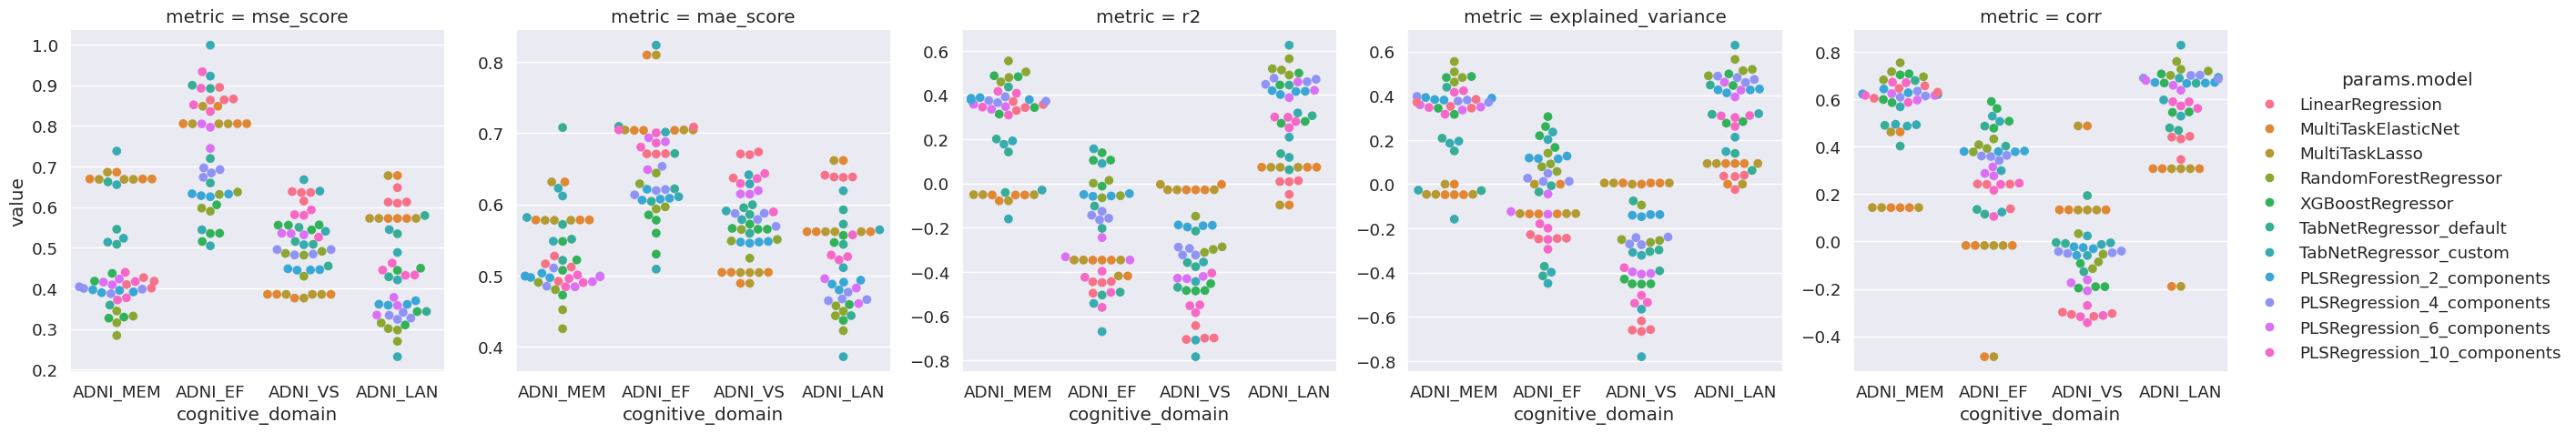

In [ ]:
df_plot_loonona_ajd = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_adj"]
df_plot_loonona_org = df_results_loonona_radar[df_results_loonona_radar['result_domain'] == "results_org"]

sns.catplot(data=df_plot_loonona_ajd, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

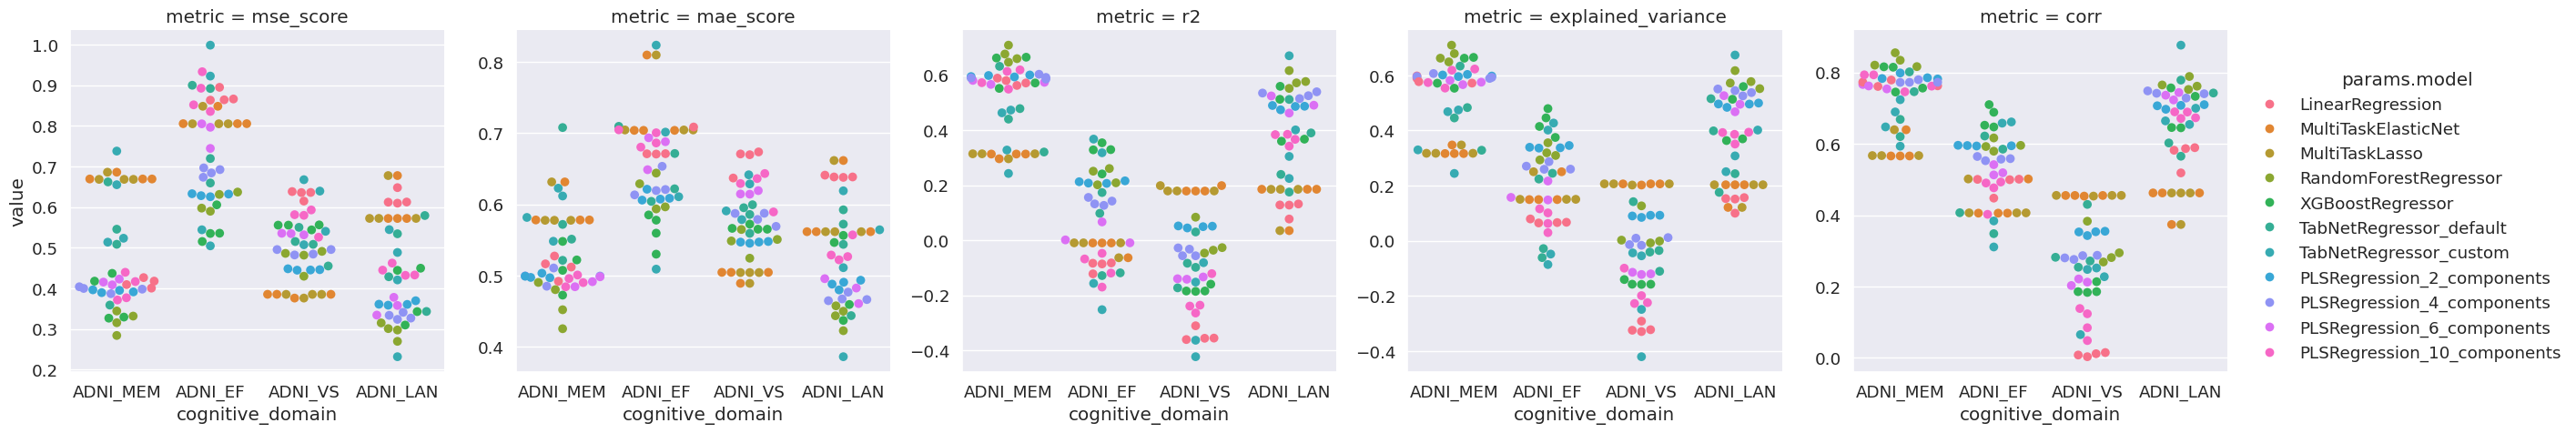

In [ ]:
sns.catplot(data=df_plot_loonona_org, x="cognitive_domain", y="value", col = "metric", hue="params.model", kind="swarm", sharey=False, size=7,  aspect=1)

In [ ]:
df_plot_loonona_org["params.test_rid"]

860     [15, 69, 88, 680, 886, 957, 1099, 1116, 1276, ...
861     [15, 69, 88, 680, 886, 957, 1099, 1116, 1276, ...
862     [15, 69, 88, 680, 886, 957, 1099, 1116, 1276, ...
863     [15, 69, 88, 680, 886, 957, 1099, 1116, 1276, ...
864     [15, 69, 88, 680, 886, 957, 1099, 1116, 1276, ...
                              ...                        
1715    [RID, VISCODE, ORIGPROT, COLPROT, USERDATE, EX...
1716    [RID, VISCODE, ORIGPROT, COLPROT, USERDATE, EX...
1717    [RID, VISCODE, ORIGPROT, COLPROT, USERDATE, EX...
1718    [RID, VISCODE, ORIGPROT, COLPROT, USERDATE, EX...
1719    [RID, VISCODE, ORIGPROT, COLPROT, USERDATE, EX...
Name: params.test_rid, Length: 860, dtype: object

In [ ]:
select.keys()

dict_keys(['ADNI_cog', 'RNA', 'CSF', 'DNA', 'MRIth', 'MRIvol', 'PET'])

In [ ]:
df_feat = pd.concat([df_X, df_y], axis=1)

In [ ]:
sns.color_palette(cat_palette.values())

[(0.9215686274509803, 0.9294117647058824, 0.4470588235294118),
 (0.47843137254901963, 0.8470588235294118, 0.9215686274509803),
 (0.24705882352941178, 0.2823529411764706, 0.3803921568627451),
 (0.8705882352941177, 0.47058823529411764, 0.34901960784313724),
 (0.4588235294117647, 0.7490196078431373, 0.6666666666666666)]

In [ ]:
# Create an empty list to store the keys
keys_list = []

# Iterate over the columns of the DataFrame
for col in df_feat.columns:
    for key, values in select.items():
        if col in values:
            keys_list.append(key)
            break

# Print the list of keys
print(keys_list)

['RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'RNA', 'CSF', 'CSF', 'CSF', 'DNA', 'DNA', 'DNA', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIth', 'MRIt

In [ ]:
id_list = np.arange(0, len(keys_list))
new_id_list = []
new_key_list = []
for mod in ["MRIth", "RNA", "CSF", "DNA", "ADNI_cog"]: 
    is_modal = [i == mod for i in keys_list]
    new_id_list.extend(id_list[is_modal])
    new_key_list.extend(np.array(keys_list)[is_modal])

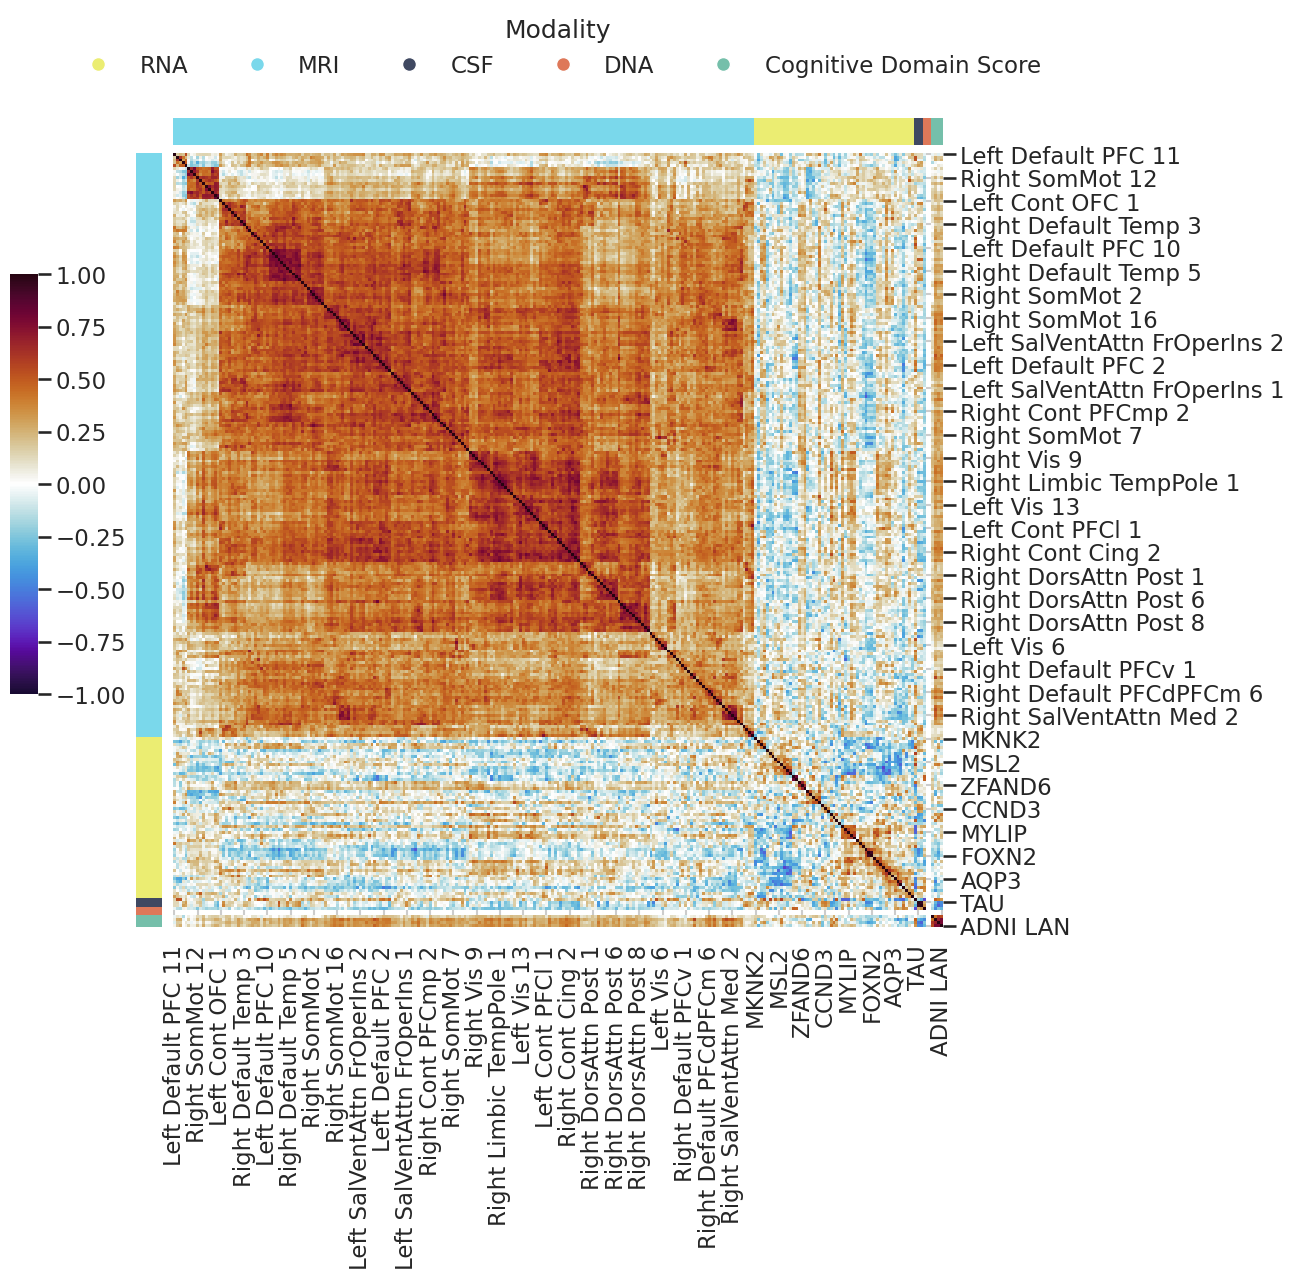

In [ ]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list

from matplotlib.patches import Patch

row_colors = pd.Series(new_key_list).map(cat_palette)
row_colors

df_corr = df_feat.iloc[new_id_list, new_id_list].corr()


# Perform subcategory-specific clustering
ordered_indices = []
for subcategory in ["MRIth", "RNA", "CSF", "DNA", "ADNI_cog"]:
    # Identify rows/columns belonging to the subcategory
    subcategory_mask = [key == subcategory for key in new_key_list]
    subcategory_indices = np.where(subcategory_mask)[0]
    
    if len(subcategory_indices) > 1:  # Ensure there are enough entries to cluster
        subcategory_data = df_corr.iloc[subcategory_indices, subcategory_indices]
        subcategory_data = subcategory_data.fillna(0) 
        
        # Compute distance matrix and linkage
        dist_matrix = pdist(subcategory_data, metric="euclidean")
        linkage_matrix = linkage(dist_matrix, method="average")
        
        # Get the order of leaves
        subcategory_order = [subcategory_indices[i] for i in leaves_list(linkage_matrix)]
        ordered_indices.extend(subcategory_order)
    else:
        ordered_indices.extend(subcategory_indices)  # Add single entries as-is

# Reorder the correlation matrix and row_colors
df_corr_reordered = df_corr.iloc[ordered_indices, ordered_indices]
row_colors_reordered = pd.Series(np.array(new_key_list)[ordered_indices]).map(cat_palette)

# Plot the updated clustermap
g = sns.clustermap(
    df_corr_reordered,
    figsize=(14, 14),
    dendrogram_ratio=0.1,
    row_colors=row_colors_reordered.values,
    col_colors=row_colors_reordered.values,
    method="centroid",
    row_cluster=False,
    col_cluster=False,
    cmap=cm_div,
    vmin=-1,
    vmax=1,
    cbar_pos=(0, 0.5, 0.02, 0.3),
)


g.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
g.ax_col_dendrogram.set_visible(False) 

ytick_labels = [tick.get_text() for tick in g.ax_heatmap.get_yticklabels()]
xtick_labels = [tick.get_text() for tick in g.ax_heatmap.get_xticklabels()]

def replace_ax_ticks(axtick_labels): 
    # Update tick labels
    new_labels = [clean_ytick_label(label) for label in axtick_labels]
    label_dict = {
        "ADNIMEM": "Memory",
        "ADNI EF": "Executive \n Function",  # Added \n for the line break
        "ADNI VS": "Visuospatial",
        "ADNI LAN": "Language"
    }
    for key, value in label_dict.items():
        for i in new_labels:
            i = i.replace(key, value)

    return new_labels

#ax.set_yticklabels([new_labels.replace('_', ' + ').replace  for label in ax.get_yticklabels()])

g.ax_heatmap.set_yticklabels(replace_ax_ticks(ytick_labels))
g.ax_heatmap.set_xticklabels(replace_ax_ticks(xtick_labels))

# Add a custom legend for group_colors at the top
handles, labels = [], []
for label, color in cat_palette.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(label.replace('MRIth', 'MRI').replace('ADNI_cog', 'Cognitive Domain Score'))

# Position the legend at the top, horizontally
g.ax_heatmap.legend(handles, labels, title="Modality", loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=5, frameon=False)

# Save the updated plot
plt.savefig("../figures/heatmap_subcategory_clustering.png", format="png", bbox_inches="tight", dpi=300)


In [ ]:
full_palette_graph

{'orange': '#de7859',
 'yellow': '#ebed72',
 'blue': '#3f4861',
 'cyan': '#7ad8eb',
 'purple': '#b1a7cf',
 'green': '#75bfaa'}

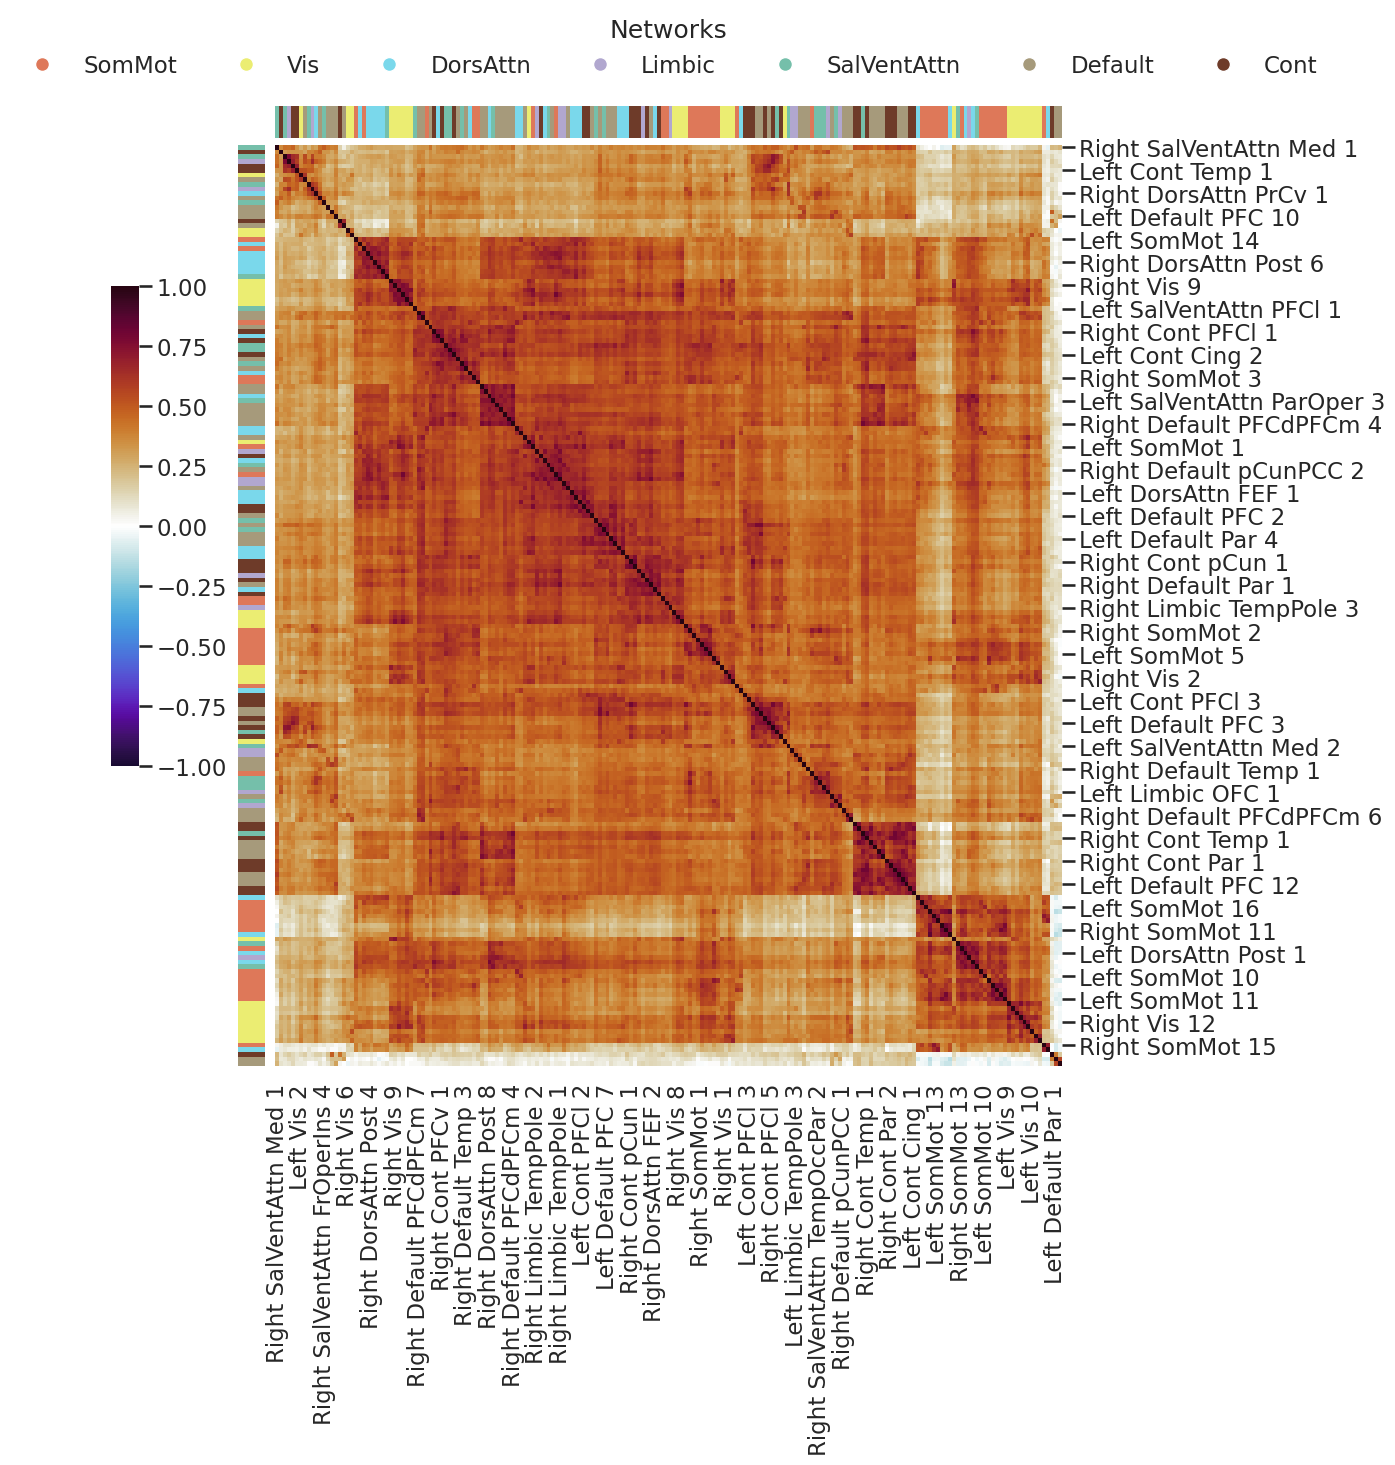

In [ ]:
from matplotlib.patches import Patch

net_palette = {'SomMot': full_palette_graph["orange"],
 'Vis': full_palette_graph["yellow"],
 'DorsAttn': full_palette_graph["cyan"],
 'Limbic': full_palette_graph["purple"],
 'SalVentAttn': full_palette_graph["green"],
 'Default': "#a69a7b",
 'Cont': "#6e3b29"}

lst_network = [x.split('_')[1] for x in df_X[select["MRIth"]]]

row_colors = pd.Series(lst_network).map(net_palette)

df_data = df_X[select["MRIth"]].corr()

g = sns.clustermap(df_data, figsize=(14,16), dendrogram_ratio=0.1, 
               row_colors=row_colors.values, 
               col_colors=row_colors.values, 
               method="centroid", 
               cmap=cm_div, vmin=-1, vmax=1,
               cbar_pos=(0, 0.5, 0.02, .3))

g.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
g.ax_col_dendrogram.set_visible(False) 

ytick_labels = [tick.get_text() for tick in g.ax_heatmap.get_yticklabels()]
xtick_labels = [tick.get_text() for tick in g.ax_heatmap.get_xticklabels()]

def replace_ax_ticks(axtick_labels): 
    # Update tick labels
    new_labels = [clean_ytick_label(label) for label in axtick_labels]
    label_dict = {
        "ADNI MEM": "Memory",
        "ADNI EF": "Executive \n Function",  # Added \n for the line break
        "ADNI VS": "Visuospatial",
        "ADNI LAN": "Language"
    }
    for key, value in label_dict.items():
        for i in new_labels:
            i = i.replace(key, value)

    return new_labels

#ax.set_yticklabels([new_labels.replace('_', ' + ').replace  for label in ax.get_yticklabels()])

g.ax_heatmap.set_yticklabels(replace_ax_ticks(ytick_labels))
g.ax_heatmap.set_xticklabels(replace_ax_ticks(xtick_labels))

# Add a custom legend for group_colors at the top
handles, labels = [], []
for label, color in net_palette.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(label.replace('MRIth', 'MRI').replace( 'ADNI_cog', 'Cognitive Domain Score'))

# Position the legend at the top, horizontally
g.ax_heatmap.legend(handles, labels, title="Networks", loc="upper center", bbox_to_anchor=(0.5, 1.16), ncol=7, frameon=False)

In [ ]:
full_palette_graph

{'orange': '#de7859',
 'yellow': '#ebed72',
 'blue': '#3f4861',
 'cyan': '#7ad8eb',
 'purple': '#b1a7cf',
 'green': '#75bfaa'}

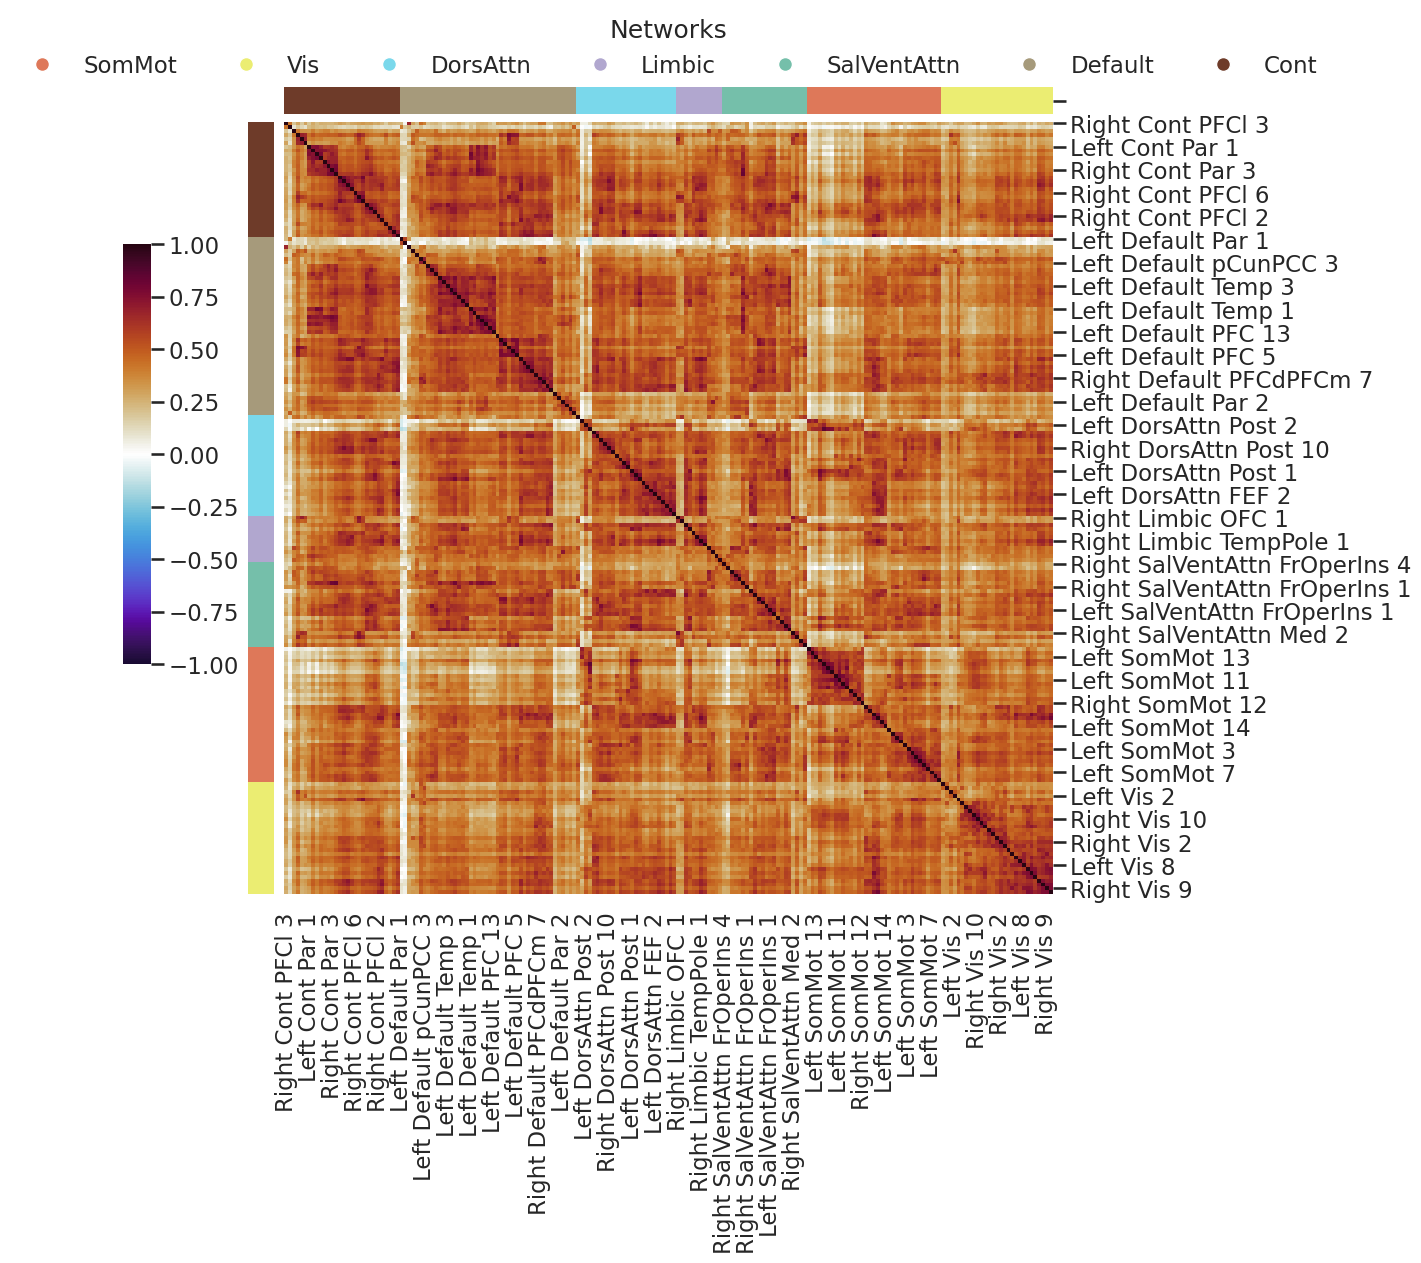

In [ ]:
from matplotlib.patches import Patch

net_palette = {'SomMot': full_palette_graph["orange"],
 'Vis': full_palette_graph["yellow"],
 'DorsAttn': full_palette_graph["cyan"],
 'Limbic': full_palette_graph["purple"],
 'SalVentAttn': full_palette_graph["green"],
 'Default': "#a69a7b",
 'Cont': "#6e3b29"}

lst_network = [x.split('_')[1] for x in df_X[select["MRIth"]]]

row_colors = pd.Series(lst_network).map(net_palette)

df_corr = df_X[select["MRIth"]].corr()

ordered_features = []

# Perform hierarchical clustering within each network
for network in np.unique(lst_network):
    # Get features belonging to the current network
    network_features = [feature for feature, net in zip(df_corr.columns, lst_network) if net == network]

    # Subset the correlation matrix for the network
    network_corr = df_corr.loc[network_features, network_features]

    # Convert correlation to distance
    distance = 1 - network_corr

    # Perform hierarchical clustering
    linkage_matrix = linkage(squareform(distance), method='average')
    network_order = np.array(network_features)[leaves_list(linkage_matrix)]

    # Append ordered features
    ordered_features.extend(network_order)

# Reorder the correlation matrix
ordered_corr = df_corr.loc[ordered_features, ordered_features]

g = sns.clustermap(ordered_corr, figsize=(14,14), dendrogram_ratio=0.1, 
            row_colors=pd.Series(lst_network, index=df_corr.index).map(net_palette),
            col_colors=pd.Series(lst_network, index=df_corr.index).map(net_palette),
            row_cluster=False,
            col_cluster=False,
            method="centroid", 
            cmap=cm_div, vmin=-1, vmax=1,
            cbar_pos=(0, 0.5, 0.02, .3))

g.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
g.ax_col_dendrogram.set_visible(False) 

ytick_labels = [tick.get_text() for tick in g.ax_heatmap.get_yticklabels()]
xtick_labels = [tick.get_text() for tick in g.ax_heatmap.get_xticklabels()]

def replace_ax_ticks(axtick_labels): 
    # Update tick labels
    new_labels = [clean_ytick_label(label) for label in axtick_labels]
    label_dict = {
        "ADNI MEM": "Memory",
        "ADNI EF": "Executive \n Function",  # Added \n for the line break
        "ADNI VS": "Visuospatial",
        "ADNI LAN": "Language"
    }
    for key, value in label_dict.items():
        for i in new_labels:
            i = i.replace(key, value)

    return new_labels

#ax.set_yticklabels([new_labels.replace('_', ' + ').replace  for label in ax.get_yticklabels()])

g.ax_heatmap.set_yticklabels(replace_ax_ticks(ytick_labels))
g.ax_heatmap.set_xticklabels(replace_ax_ticks(xtick_labels))

# Add a custom legend for group_colors at the top
handles, labels = [], []
for label, color in net_palette.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(label.replace('MRIth', 'MRI').replace( 'ADNI_cog', 'Cognitive Domain Score'))

# Position the legend at the top, horizontally
g.ax_heatmap.legend(handles, labels, title="Networks", loc="upper center", bbox_to_anchor=(0.5, 1.16), ncol=7, frameon=False)

In [ ]:
df_X[select["MRIth"]].shape

(2894, 200)

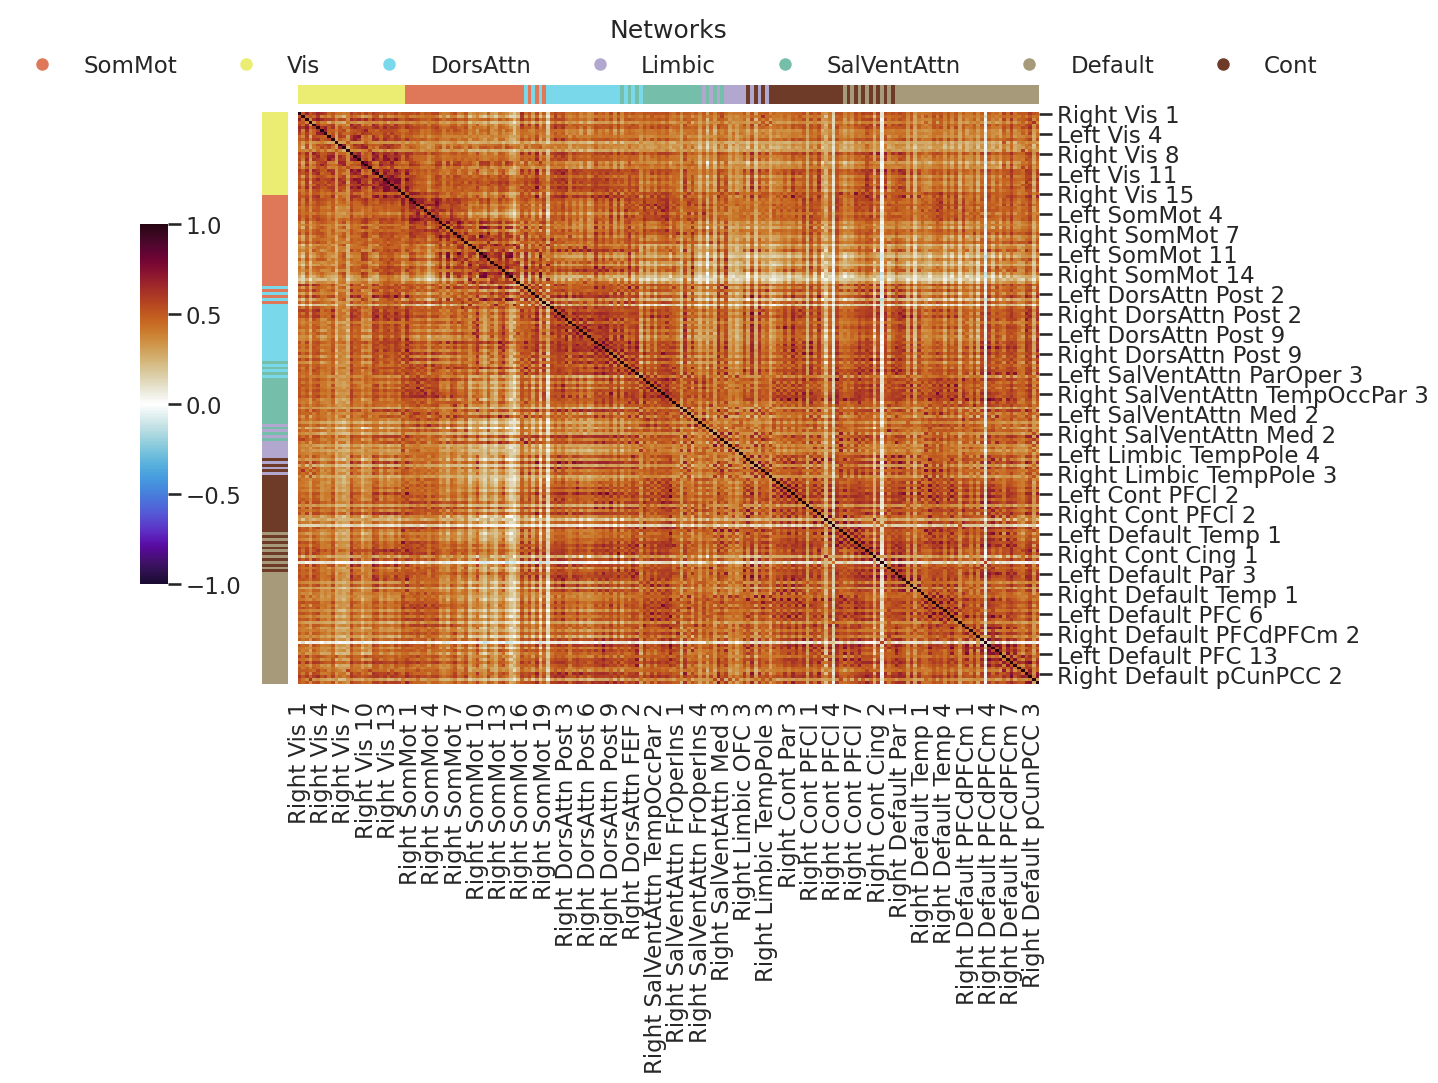

In [ ]:
from matplotlib.patches import Patch

net_palette = {'SomMot': full_palette_graph["orange"],
 'Vis': full_palette_graph["yellow"],
 'DorsAttn': full_palette_graph["cyan"],
 'Limbic': full_palette_graph["purple"],
 'SalVentAttn': full_palette_graph["green"],
 'Default': "#a69a7b",
 'Cont': "#6e3b29"}

lst_network = [x.split('_')[1] for x in df_X[select["MRIth"]]]

row_colors = pd.Series(lst_network).map(net_palette)

df_data = df_X[select["MRIth"]].corr()

g = sns.clustermap(df_data, figsize=(14,12), dendrogram_ratio=0.1, 
               row_colors=row_colors.values, 
               col_colors=row_colors.values, 
               method="centroid", 
               row_cluster=False,
               col_cluster=False,
               cmap=cm_div, vmin=-1, vmax=1,
               cbar_pos=(0, 0.5, 0.02, .3))

g.ax_row_dendrogram.set_visible(False) #suppress row dendrogram
g.ax_col_dendrogram.set_visible(False) 

ytick_labels = [tick.get_text() for tick in g.ax_heatmap.get_yticklabels()]
xtick_labels = [tick.get_text() for tick in g.ax_heatmap.get_xticklabels()]

def replace_ax_ticks(axtick_labels): 
    # Update tick labels
    new_labels = [clean_ytick_label(label) for label in axtick_labels]
    label_dict = {
        "ADNI MEM": "Memory",
        "ADNI EF": "Executive \n Function",  # Added \n for the line break
        "ADNI VS": "Visuospatial",
        "ADNI LAN": "Language"
    }
    for key, value in label_dict.items():
        for i in new_labels:
            i = i.replace(key, value)

    return new_labels
4
#ax.set_yticklabels([new_labels.replace('_', ' + ').replace  for label in ax.get_yticklabels()])

g.ax_heatmap.set_yticklabels(replace_ax_ticks(ytick_labels))
g.ax_heatmap.set_xticklabels(replace_ax_ticks(xtick_labels))

# Add a custom legend for group_colors at the top
handles, labels = [], []
for label, color in net_palette.items():
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10))
    labels.append(label.replace('MRIth', 'MRI').replace( 'ADNI_cog', 'Cognitive Domain Score'))

# Position the legend at the top, horizontally
g.ax_heatmap.legend(handles, labels, title="Networks", loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=7, frameon=False)

<Axes: xlabel='NSUN6', ylabel='DX'>

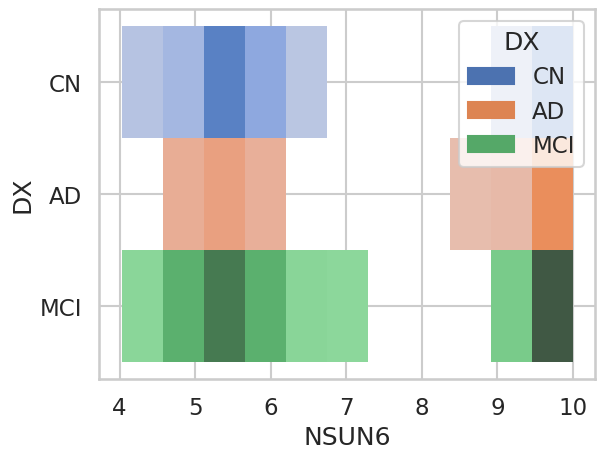

In [ ]:
sns.histplot(data=pd.concat([df_X[["NSUN6", "MMGT1", "CD300E"]], df_all.DX], axis=1).dropna().drop_duplicates(), x="NSUN6", y="DX", hue="DX", kde=True)

<Axes: xlabel='CD300E', ylabel='Count'>

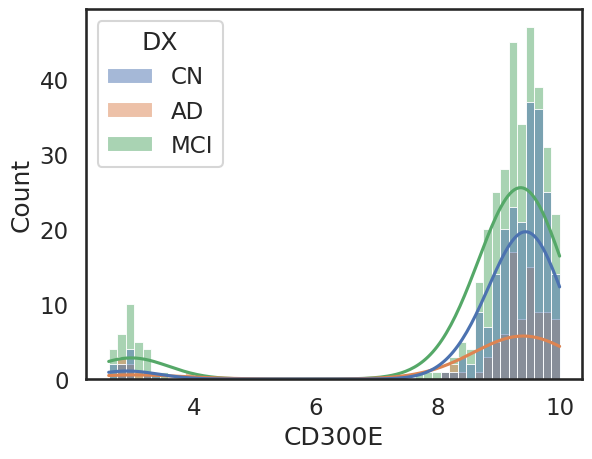

In [ ]:
sns.histplot(data=pd.concat([df_X[["NSUN6", "MMGT1", "CD300E"]], df_all.DX], axis=1).dropna().drop_duplicates(), x="CD300E", hue="DX", kde=True)

<Axes: xlabel='CD300E', ylabel='Count'>

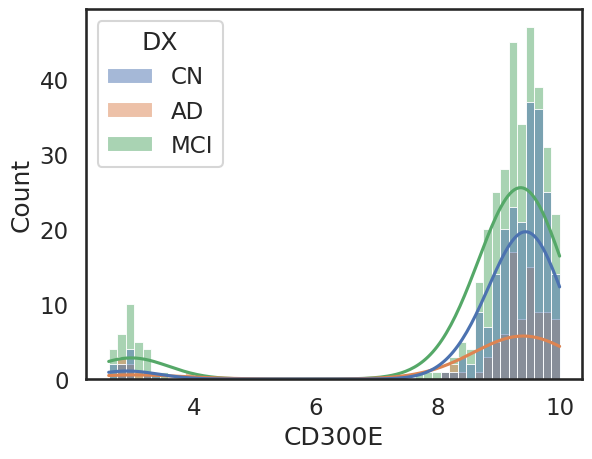

In [ ]:
sns.histplot(data=pd.concat([df_X[["NSUN6", "MMGT1", "CD300E"]], df_all.DX], axis=1).dropna().drop_duplicates(), x="CD300E", hue="DX", kde=True)

<Axes: xlabel='CD300E', ylabel='Count'>

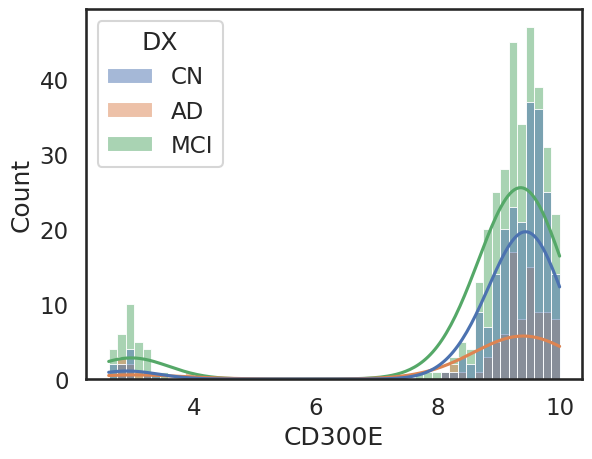

In [ ]:
sns.histplot(data=pd.concat([df_X[["NSUN6", "MMGT1", "CD300E"]], df_all.DX], axis=1).dropna().drop_duplicates(), x="CD300E", hue="DX", kde=True)

In [ ]:
df_X[select["RNA"]].dropna().drop_duplicates()

ARG1  ATP8B5P || ZFAND6  C17ORF103  C6ORF25    CLU  CORO2B  CTNNB1  \
23    4.101              5.555      4.590    8.952  9.645   5.686   4.308   
47    5.444              5.447      4.435    8.979  9.645   2.633   9.948   
64    4.091              5.214      4.567    8.516  9.027   2.839   4.730   
84    4.719              5.555      4.164    7.589  9.111   3.778   4.746   
128   6.386              5.364      4.784    9.581  9.667   5.616   4.622   
...     ...                ...        ...      ...    ...     ...     ...   
8717  7.777              5.447      9.904    7.752  9.182   2.791   9.944   
8734  7.540              5.973      4.510    9.351  9.774   4.859   9.851   
8756  5.976              5.235      4.531    2.845  3.659   2.979   4.504   
8768  5.797              5.690      9.621    8.816  9.643   4.087   9.931   
8778  6.758              9.921      4.523    8.695  9.500   3.109   9.434   

      DACT1  ELOVL5   FOLR3  ...   ORM1  OXSR1  PILRA  PRICKLE3  PRKACA  \
23    4.335   9.755   7.177  ...  7.581  9.672  3.867     4.085   4.911   
47    3.122   9.753   7.083  ...  7.837  9.826  3.570     3.529   5.734   
64    6.568   9.704   6.291  ...  7.569  9.921  3.822     3.803   9.988   
84    5.927   4.537   6.857  ...  7.490  9.762  3.933     3.870   9.821   
128   6.423   4.138   6.973  ...  8.327  4.198  3.831     9.638   5.002   
...     ...     ...     ...  ...    ...    ...    ...       ...     ...   
8717  3.500   9.505   8.979  ...  7.935  5.209  4.117     4.399   6.124   
8734  5.584   9.897   7.758  ...  8.782  9.628  3.984     4.234   6.047   
8756  5.736   9.978   7.878  ...  6.097  9.957  3.983     3.649   5.941   
8768  3.571   9.585   9.929  ...  5.018  9.729  4.159     4.128   9.998   
8778  3.410   9.276  10.483  ...  9.645  9.626  4.273     3.616   6.277   

       RCC2    RPL9  TGFBR2  TMED2  ZFC3H1  
23    4.602   9.349   9.381  4.178   6.108  
47    9.703   9.666   4.562  4.137   5.795  
64    4.677   9.158   4.776  4.770   6.077  
84    4.221  11.515   4.235  5.437   6.270  
128   9.989   9.580   9.984  4.775   6.738  
...     ...     ...     ...    ...     ...  
8717  9.786   9.324   9.411  3.140   5.952  
8734  9.798   2.200   5.021  4.378   6.078  
8756  4.952   9.863   9.980  3.780   5.746  
8768  4.538   9.081   9.814  4.555   6.161  
8778  9.863   9.504   9.798  3.291   9.842  

[590 rows x 74 columns]

<Axes: xlabel='FOLR3', ylabel='Count'>

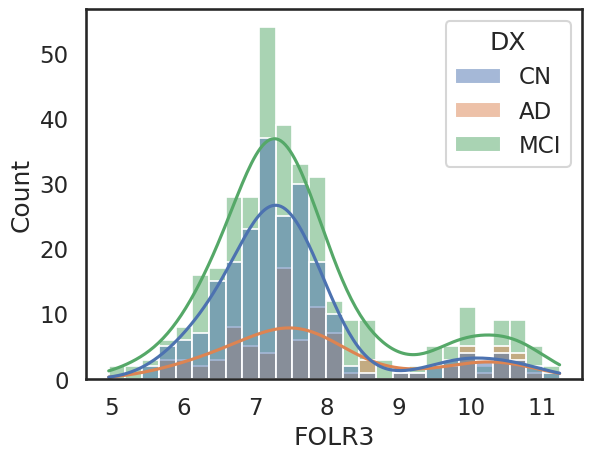

In [ ]:
sns.histplot(data=pd.concat([df_X[["DACT1", "FOLR3"]], df_all.DX], axis=1).dropna().drop_duplicates(), x="FOLR3", hue="DX", kde=True)

<Axes: xlabel='FOLR3'>

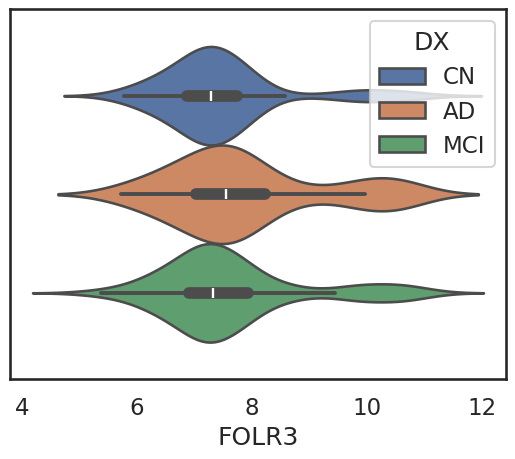

In [ ]:
sns.violinplot(data=pd.concat([df_X[["DACT1", "FOLR3"]], df_all.DX], axis=1).dropna().drop_duplicates(), x="FOLR3", hue="DX")

<Axes: xlabel='FOLR3'>

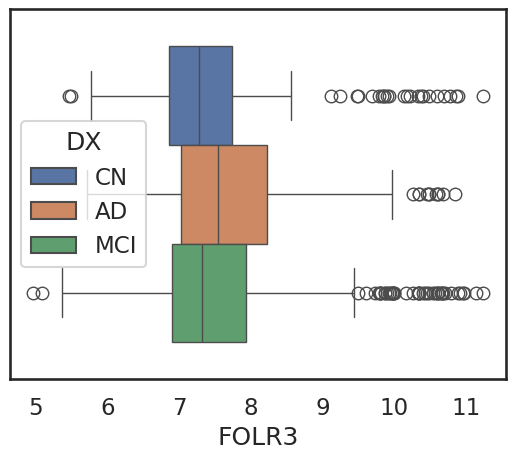

In [ ]:
sns.boxplot(data=pd.concat([df_X[["DACT1", "FOLR3"]], df_all.DX], axis=1).dropna().drop_duplicates(), x="FOLR3", hue="DX")